Nick Videtti \
IST 718 - Big Data Analytics \
Lab 2 \
Summer 2023 \
\
&nbsp;&nbsp;&nbsp;&nbsp;This lab activity will take time-series data from Zillow and combine it with geospatial data to perform the following tasks. \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Exploratory Data Analysis Using Pandas DataFrames and Seaborn/PyPlot visualizations \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Time Series Modeling Using ARIMA Models from the statsmodels package \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Find the top/bottom zip codes for various states/regions \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Answer the following questions: \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;o What techniques/algorithms/decision processes were used to down sample? (Will be necessary due to local machine memory restrictions and model generation latency) \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;o What three zip codes provide the best investment opportunity for the SREIT (Syracuse Real Estate Investment Trust)?

The first step will be to read in the Zillow data and evaulate the schema to see if it needs any changes, or if any column names or column values need to be transformed. This is a CSV file that will selected by the user via file dialog and the data will be read into a Pandas DataFrame. Once the data are read in, we will look at the DataFrame.

In [9]:
import pandas
import tkinter.filedialog

zillow_path = tkinter.filedialog.askopenfile(title = 'Please Choose Zillow Data File...').name
zillow_data = pandas.read_csv(zillow_path)

zillow_data

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-02-29,...,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30
0,61148,0,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,134364.907282,...,643652.668634,646814.356463,651045.877085,648749.930724,649357.058088,654877.720755,664104.660045,674844.940254,683958.991189,691478.823788
1,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,181536.838310,...,508647.534120,505187.850882,501656.093356,496785.246305,493691.058652,495363.350794,499448.423481,504181.356100,510051.884974,515758.881910
2,91940,2,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,111858.834149,...,287474.656560,285574.045729,283150.604052,280455.531881,278166.827948,277297.685136,278154.500513,278679.294743,280273.275280,282701.612620
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,178283.760706,...,867132.185179,864594.125765,868704.191564,860713.945533,858848.573343,850399.932873,840457.589188,833773.288911,837261.976495,845559.300014
4,92593,4,78660,zip,TX,TX,Pflugerville,"Austin-Round Rock-Georgetown, TX",Travis County,175940.813286,...,461465.345097,452935.721693,443513.417895,434831.543058,431084.452411,429144.677762,428768.925807,429655.021585,432024.710356,434362.453688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,93941,39809,82515,zip,WY,WY,Riverton,"Riverton, WY",Fremont County,NaN,...,196040.755601,196014.429586,195537.401813,192920.045108,195894.786175,195892.946669,197151.789885,199781.876316,202289.342131,202874.294500
29527,98279,39809,95556,zip,CA,CA,Orleans,"Eureka-Arcata, CA",Humboldt County,NaN,...,331568.501822,322779.067902,311038.543039,302731.811642,324474.937672,327159.675560,320420.645374,320068.496191,316330.601825,303317.310982
29528,97314,39809,93530,zip,CA,CA,Olancha,NaN,Inyo County,NaN,...,100758.002806,98718.504065,95255.080383,94410.351133,86762.394798,91755.528582,98573.745064,103908.974777,109287.633063,111940.058669
29529,62723,39809,12752,zip,NY,NY,Lake Huntington,NaN,Sullivan County,68662.753560,...,295056.415824,294342.331796,291923.193383,286466.166265,286699.915575,288108.771271,288337.394571,291755.092451,297552.347810,304689.249287


There a a few thins right off the bat to consider. The data need to be stacked, at least the date columns with quantities. Also, some columns appear to be irrelevant, not ideally named, in the wrong format, or a combination of those things. First, it is important to figure out what the granularity of these data are. It appears that the RegionID column could be a unique identifier, but it also seems that the RegionType and RegionName columns could compose their own uniqueness per row. RegionName seems to simply be the zip code, it is assumed to be for rows where RegionType is "zip". But is the RegionType column always "zip"?

In [10]:
set(zillow_data.RegionType)

{'zip'}

It appears that it is! This shows that the column is not useful. If we are lucky, this will also mean that RegionName (or zip code) is unique for each row. Let's check that out now.

In [11]:
print('Number of Rows in Zillow Data:', len(zillow_data))
print('Number Distinct RegionName', len(set(zillow_data['RegionName'])))

Number of Rows in Zillow Data: 29531
Number Distinct RegionName 29531


Great news! This is confirmation that RegionName is indeed unique for each row. It is also confimation that the RegionID and RegionType columns will not be needed.

There also seems to be some redundancy with the "StateName" and "State" columns. Hopefully these are always the same and the "StateName" column can just be ignored. Let's see if that's the case or not.

In [12]:
len(zillow_data[zillow_data['StateName'] != zillow_data['State']])

0

Great! Another nice and easy result!!

There are certainly some more possible transformations to investigate, but knowing one of those will be stacking certain columns and hence heavily increasing the number of rows, it is a good time to add in the geospatial data that will later be used for geographical visualizations. This file was found at https://gist.github.com/erichurst/7882666. It is a CSV file that will be read in the same way the Zillow data file was, selection by the user via file dialog and read into a Pandas DataFrame.

In [13]:
zip_coord_path = tkinter.filedialog.askopenfile(title = 'Please Choose Zip Code Coordinates Data File...').name
zip_coord_data = pandas.read_csv(zip_coord_path)

zip_coord_data

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135
...,...,...,...
33139,99923,56.002315,-130.041026
33140,99925,55.550204,-132.945933
33141,99926,55.138352,-131.470424
33142,99927,56.239062,-133.457924


These data look like they are schematically ready to be joined with the Zillow data. We will now inner join the two DataFrames and will look at the number of rows that are lost due to mismatches and print the combined DataFrame.

In [14]:
data = zillow_data.merge(zip_coord_data, left_on = 'RegionName', right_on = 'ZIP')

print('Rows in Zillow Data:', len(zillow_data))
print('Rows in Zip Code Coordinates Data:', len(zip_coord_data))
print('Rows in Combined Data:', len(data))
print('Rows Lost in Inner Join (No Matching Zip Code Coordinates):', len(zillow_data) - len(data))

print()
print('COMBINED DATA')
data

Rows in Zillow Data: 29531
Rows in Zip Code Coordinates Data: 33144
Rows in Combined Data: 29315
Rows Lost in Inner Join (No Matching Zip Code Coordinates): 216

COMBINED DATA


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-02-29,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,ZIP,LAT,LNG
0,61148,0,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,134364.907282,...,648749.930724,649357.058088,654877.720755,664104.660045,674844.940254,683958.991189,691478.823788,8701,40.077041,-74.200383
1,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,181536.838310,...,496785.246305,493691.058652,495363.350794,499448.423481,504181.356100,510051.884974,515758.881910,77494,29.740677,-95.829652
2,91940,2,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,111858.834149,...,280455.531881,278166.827948,277297.685136,278154.500513,278679.294743,280273.275280,282701.612620,77449,29.837572,-95.733754
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,178283.760706,...,860713.945533,858848.573343,850399.932873,840457.589188,833773.288911,837261.976495,845559.300014,11368,40.751718,-73.851822
4,92593,4,78660,zip,TX,TX,Pflugerville,"Austin-Round Rock-Georgetown, TX",Travis County,175940.813286,...,434831.543058,431084.452411,429144.677762,428768.925807,429655.021585,432024.710356,434362.453688,78660,30.439630,-97.594687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29310,93941,39809,82515,zip,WY,WY,Riverton,"Riverton, WY",Fremont County,NaN,...,192920.045108,195894.786175,195892.946669,197151.789885,199781.876316,202289.342131,202874.294500,82515,42.903732,-108.542611
29311,98279,39809,95556,zip,CA,CA,Orleans,"Eureka-Arcata, CA",Humboldt County,NaN,...,302731.811642,324474.937672,327159.675560,320420.645374,320068.496191,316330.601825,303317.310982,95556,41.324926,-123.600968
29312,97314,39809,93530,zip,CA,CA,Olancha,NaN,Inyo County,NaN,...,94410.351133,86762.394798,91755.528582,98573.745064,103908.974777,109287.633063,111940.058669,93530,36.475830,-117.860116
29313,62723,39809,12752,zip,NY,NY,Lake Huntington,NaN,Sullivan County,68662.753560,...,286466.166265,286699.915575,288108.771271,288337.394571,291755.092451,297552.347810,304689.249287,12752,41.680039,-74.994190


All things considered, losing only 216 rows of data is not too bad. Now that the data are all combined, it is finally time to do our transformations. These transformations will be dropping columns, renaming columns, making the zip codes 5 character strings so that they have leading zeros, stacking the date columns, and some other transformations. The resulting DataFrame will be printed.

In [15]:
data = data.drop(columns = ['RegionType', 'StateName', 'ZIP'])

data = data.rename(columns = {'RegionName': 'ZipCode', 'CountyName': 'County', 'LAT': 'Latitude', 'LNG': 'Longitude'})

data['ZipCode'] = ('00000' + data['ZipCode'].astype(str)).str.slice(-5)

data['County'] = data['County'].str.replace('County','').str.strip()

stacked_columns = [column for column in data.columns if not column in ('RegionID', 'SizeRank', 'ZipCode', 'State', 'City', 'Metro', 'County', 'Latitude', 'Longitude')]

zillow_stacked_numerics_dates = data[stacked_columns].stack().to_frame().fillna(0)

zillow_stacked_numerics_dates['Date'] = [index[1] for index in zillow_stacked_numerics_dates.index]

zillow_stacked_numerics_dates.index = [index[0] for index in zillow_stacked_numerics_dates.index]

zillow_stacked_numerics_dates = zillow_stacked_numerics_dates[['Date', 0]].rename(columns = {0: 'Quantity'})

data = data[['RegionID', 'SizeRank', 'ZipCode', 'Latitude', 'Longitude', 'State', 'City', 'Metro', 'County']].merge(zillow_stacked_numerics_dates, left_index = True, right_index = True).reset_index(drop = True)

data

,RegionID,SizeRank,ZipCode,Latitude,Longitude,State,City,Metro,County,Date,Quantity
0,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-02-29,134364.907282
1,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-03-31,133403.054308
2,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-04-30,132808.029203
3,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-05-31,132741.165100
4,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-06-30,132494.980625
...,...,...,...,...,...,...,...,...,...,...,...
7616598,63723,39809,14774,42.088367,-78.149093,NY,Richburg,NaN,Allegany,2023-02-28,69960.657982
7616599,63723,39809,14774,42.088367,-78.149093,NY,Richburg,NaN,Allegany,2023-03-31,67845.804086
7616600,63723,39809,14774,42.088367,-78.149093,NY,Richburg,NaN,Allegany,2023-04-30,67006.892536
7616601,63723,39809,14774,42.088367,-78.149093,NY,Richburg,NaN,Allegany,2023-05-31,67429.846236


Looks great! In fact, almost perfect!! To ensure everything is correct, we will look for any missing values. It looks like Metro has some missing values, but every column will be looked at.

In [16]:
for column in data.columns: print(column, len([value for value in data[column].isna() if value == True]))

RegionID 0
SizeRank 0
ZipCode 0
Latitude 0
Longitude 0
State 0
City 277290
Metro 1404842
County 0
Date 0
Quantity 0


Looks like both "City" and "Metro" have missing values. We will replace these with "N/A" and print the resulting DataFrame.

In [17]:
data['City'] = data['City'].fillna('N/A')
data['Metro'] = data['Metro'].fillna('N/A')

for column in data.columns: print(column, len([value for value in data[column].isna() if value == True]))

data

RegionID 0
SizeRank 0
ZipCode 0
Latitude 0
Longitude 0
State 0
City 0
Metro 0
County 0
Date 0
Quantity 0


,RegionID,SizeRank,ZipCode,Latitude,Longitude,State,City,Metro,County,Date,Quantity
0,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-02-29,134364.907282
1,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-03-31,133403.054308
2,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-04-30,132808.029203
3,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-05-31,132741.165100
4,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996-06-30,132494.980625
...,...,...,...,...,...,...,...,...,...,...,...
7616598,63723,39809,14774,42.088367,-78.149093,NY,Richburg,N/A,Allegany,2023-02-28,69960.657982
7616599,63723,39809,14774,42.088367,-78.149093,NY,Richburg,N/A,Allegany,2023-03-31,67845.804086
7616600,63723,39809,14774,42.088367,-78.149093,NY,Richburg,N/A,Allegany,2023-04-30,67006.892536
7616601,63723,39809,14774,42.088367,-78.149093,NY,Richburg,N/A,Allegany,2023-05-31,67429.846236


Looks great! Now, it is time to work on the date fields. The goal is to have fields for the date, the date truncated to the beginning of the month, and the date truncated to the beginning of the year. We will want both a date field and a string field for each of these. The date field is for comparing dates and for visualization axes, while the string field is to have the date displayed in a more read-friendly format.

All of these transformations will begin with the "Date" field, so we will need to know what data types are in the "Date" field.

In [18]:
set([type(date) for date in data['Date']])

{str}

It looks like all values in the "Date" field are strings, so a dictionary will be used to map month numbers to month names. Then, the date string fields will be created and the resulting DataFrame will be printed.

In [19]:
month_names = {'01': 'January', \
    '02': 'February', \
    '03': 'March', \
    '04': 'April', \
    '05': 'May', \
    '06': 'June', \
    '07': 'July', \
    '08': 'August', \
    '09': 'September', \
    '10': 'October', \
    '11': 'November', \
    '12': 'December'}

data['MonthYearString'] = [month_names[date[5:7]] + ' ' + date[:4] for date in data['Date']]

data['YearString'] = data['MonthYearString'].str.slice(-4)

data['CityState'] = data['City'] + ', ' + data['State']

data = data[['RegionID', 'SizeRank', 'ZipCode', 'Latitude', 'Longitude', 'State', 'City', 'CityState', 'Metro', 'County', 'YearString', 'MonthYearString', 'Date', 'Quantity']]

data

,RegionID,SizeRank,ZipCode,Latitude,Longitude,State,City,CityState,Metro,County,YearString,MonthYearString,Date,Quantity
0,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,February 1996,1996-02-29,134364.907282
1,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,March 1996,1996-03-31,133403.054308
2,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,April 1996,1996-04-30,132808.029203
3,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,May 1996,1996-05-31,132741.165100
4,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,June 1996,1996-06-30,132494.980625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7616598,63723,39809,14774,42.088367,-78.149093,NY,Richburg,"Richburg, NY",N/A,Allegany,2023,February 2023,2023-02-28,69960.657982
7616599,63723,39809,14774,42.088367,-78.149093,NY,Richburg,"Richburg, NY",N/A,Allegany,2023,March 2023,2023-03-31,67845.804086
7616600,63723,39809,14774,42.088367,-78.149093,NY,Richburg,"Richburg, NY",N/A,Allegany,2023,April 2023,2023-04-30,67006.892536
7616601,63723,39809,14774,42.088367,-78.149093,NY,Richburg,"Richburg, NY",N/A,Allegany,2023,May 2023,2023-05-31,67429.846236


Now, we will want to ensure that all columns have one and only one data type. We will also wan to ensure that each of thpse columns is the data type that we want.

In [20]:
for column in data.columns: print(column + ':', len(set([type(value) for value in data[column]])), 'Distinct Types', set([type(value) for value in data[column]]))

RegionID: 1 Distinct Types {<class 'int'>}
SizeRank: 1 Distinct Types {<class 'int'>}
ZipCode: 1 Distinct Types {<class 'str'>}
Latitude: 1 Distinct Types {<class 'float'>}
Longitude: 1 Distinct Types {<class 'float'>}
State: 1 Distinct Types {<class 'str'>}
City: 1 Distinct Types {<class 'str'>}
CityState: 1 Distinct Types {<class 'str'>}
Metro: 1 Distinct Types {<class 'str'>}
County: 1 Distinct Types {<class 'str'>}
YearString: 1 Distinct Types {<class 'str'>}
MonthYearString: 1 Distinct Types {<class 'str'>}
Date: 1 Distinct Types {<class 'str'>}
Quantity: 1 Distinct Types {<class 'float'>}


Looks great! Now, we will repeat again for the date fields.

In [21]:
import datetime

data['Date'] = [datetime.date(year = int(date[:4]), month = int(date[5:7]), day = int(date[-2:])) for date in data['Date']]

data['MonthYear'] = [date.replace(day = 1) for date in data['Date']]

data['Year'] = [date.replace(month = 1) for date in data['MonthYear']]

data = data[['RegionID', 'SizeRank', 'ZipCode', 'Latitude', 'Longitude', 'State', 'City', 'CityState', 'Metro', 'County', 'YearString', 'MonthYearString', 'Year', 'MonthYear', 'Date', 'Quantity']]

data

,RegionID,SizeRank,ZipCode,Latitude,Longitude,State,City,CityState,Metro,County,YearString,MonthYearString,Year,MonthYear,Date,Quantity
0,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,February 1996,1996-01-01,1996-02-01,1996-02-29,134364.907282
1,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,March 1996,1996-01-01,1996-03-01,1996-03-31,133403.054308
2,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,April 1996,1996-01-01,1996-04-01,1996-04-30,132808.029203
3,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,May 1996,1996-01-01,1996-05-01,1996-05-31,132741.165100
4,61148,0,08701,40.077041,-74.200383,NJ,Lakewood,"Lakewood, NJ","New York-Newark-Jersey City, NY-NJ-PA",Ocean,1996,June 1996,1996-01-01,1996-06-01,1996-06-30,132494.980625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7616598,63723,39809,14774,42.088367,-78.149093,NY,Richburg,"Richburg, NY",N/A,Allegany,2023,February 2023,2023-01-01,2023-02-01,2023-02-28,69960.657982
7616599,63723,39809,14774,42.088367,-78.149093,NY,Richburg,"Richburg, NY",N/A,Allegany,2023,March 2023,2023-01-01,2023-03-01,2023-03-31,67845.804086
7616600,63723,39809,14774,42.088367,-78.149093,NY,Richburg,"Richburg, NY",N/A,Allegany,2023,April 2023,2023-01-01,2023-04-01,2023-04-30,67006.892536
7616601,63723,39809,14774,42.088367,-78.149093,NY,Richburg,"Richburg, NY",N/A,Allegany,2023,May 2023,2023-01-01,2023-05-01,2023-05-31,67429.846236


In [22]:
for column in data.columns: print(column + ':', len(set([type(value) for value in data[column]])), 'Distinct Types', set([type(value) for value in data[column]]))

RegionID: 1 Distinct Types {<class 'int'>}
SizeRank: 1 Distinct Types {<class 'int'>}
ZipCode: 1 Distinct Types {<class 'str'>}
Latitude: 1 Distinct Types {<class 'float'>}
Longitude: 1 Distinct Types {<class 'float'>}
State: 1 Distinct Types {<class 'str'>}
City: 1 Distinct Types {<class 'str'>}
CityState: 1 Distinct Types {<class 'str'>}
Metro: 1 Distinct Types {<class 'str'>}
County: 1 Distinct Types {<class 'str'>}
YearString: 1 Distinct Types {<class 'str'>}
MonthYearString: 1 Distinct Types {<class 'str'>}
Year: 1 Distinct Types {<class 'datetime.date'>}
MonthYear: 1 Distinct Types {<class 'datetime.date'>}
Date: 1 Distinct Types {<class 'datetime.date'>}
Quantity: 1 Distinct Types {<class 'float'>}


Awesome!!! Now, one last step to ensure data are ready for analysis and are fully cleaned. We will check once more to ensure that no fields have missing values.

In [23]:
for column in data.columns: print(column + ':', len(data[data[column].isnull()]), 'Missing Values')

RegionID: 0 Missing Values
SizeRank: 0 Missing Values
ZipCode: 0 Missing Values
Latitude: 0 Missing Values
Longitude: 0 Missing Values
State: 0 Missing Values
City: 0 Missing Values
CityState: 0 Missing Values
Metro: 0 Missing Values
County: 0 Missing Values
YearString: 0 Missing Values
MonthYearString: 0 Missing Values
Year: 0 Missing Values
MonthYear: 0 Missing Values
Date: 0 Missing Values
Quantity: 0 Missing Values


Perfect! Now, it is time for some Exploratory Data Analysis.

EDA will begin with looking at data for Arkansas since 1997, specifically in the metro areas of Hot Springs, Little Rock, Fayetteville, and Searcy.

In [24]:
AR_timeseries_data = data[(data['State'] == 'AR')]
AR_timeseries_data = AR_timeseries_data[AR_timeseries_data['Metro'].str.upper().str.contains('HOT SPRINGS|LITTLE ROCK|FAYETTEVILLE|SEARCY') == True]
AR_timeseries_data = AR_timeseries_data[AR_timeseries_data['YearString'].astype(int) >= 1997]


AR_timeseries_data

,RegionID,SizeRank,ZipCode,Latitude,Longitude,State,City,CityState,Metro,County,YearString,MonthYearString,Year,MonthYear,Date,Quantity
219333,89749,690,72764,36.175682,-94.060223,AR,Springdale,"Springdale, AR","Fayetteville-Springdale-Rogers, AR",Washington,1997,January 1997,1997-01-01,1997-01-01,1997-01-31,97075.868931
219334,89749,690,72764,36.175682,-94.060223,AR,Springdale,"Springdale, AR","Fayetteville-Springdale-Rogers, AR",Washington,1997,February 1997,1997-01-01,1997-02-01,1997-02-28,97063.744904
219335,89749,690,72764,36.175682,-94.060223,AR,Springdale,"Springdale, AR","Fayetteville-Springdale-Rogers, AR",Washington,1997,March 1997,1997-01-01,1997-03-01,1997-03-31,97638.141603
219336,89749,690,72764,36.175682,-94.060223,AR,Springdale,"Springdale, AR","Fayetteville-Springdale-Rogers, AR",Washington,1997,April 1997,1997-01-01,1997-04-01,1997-04-30,98576.420206
219337,89749,690,72764,36.175682,-94.060223,AR,Springdale,"Springdale, AR","Fayetteville-Springdale-Rogers, AR",Washington,1997,May 1997,1997-01-01,1997-05-01,1997-05-31,99101.964370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7005810,89289,27919,72001,35.058351,-92.885846,AR,Adona,"Adona, AR","Little Rock-North Little Rock-Conway, AR",Perry,2023,February 2023,2023-01-01,2023-02-01,2023-02-28,130116.754397
7005811,89289,27919,72001,35.058351,-92.885846,AR,Adona,"Adona, AR","Little Rock-North Little Rock-Conway, AR",Perry,2023,March 2023,2023-01-01,2023-03-01,2023-03-31,130207.407530
7005812,89289,27919,72001,35.058351,-92.885846,AR,Adona,"Adona, AR","Little Rock-North Little Rock-Conway, AR",Perry,2023,April 2023,2023-01-01,2023-04-01,2023-04-30,130886.417820
7005813,89289,27919,72001,35.058351,-92.885846,AR,Adona,"Adona, AR","Little Rock-North Little Rock-Conway, AR",Perry,2023,May 2023,2023-01-01,2023-05-01,2023-05-31,133521.854396


From here, we will create some visuals looking at quantities over time. These will be looked at by the month and will be split out by metro area. Data will need to be aggreagted first by month and metro area, and the quantities will be summed.

In [25]:
import seaborn
from matplotlib import pyplot

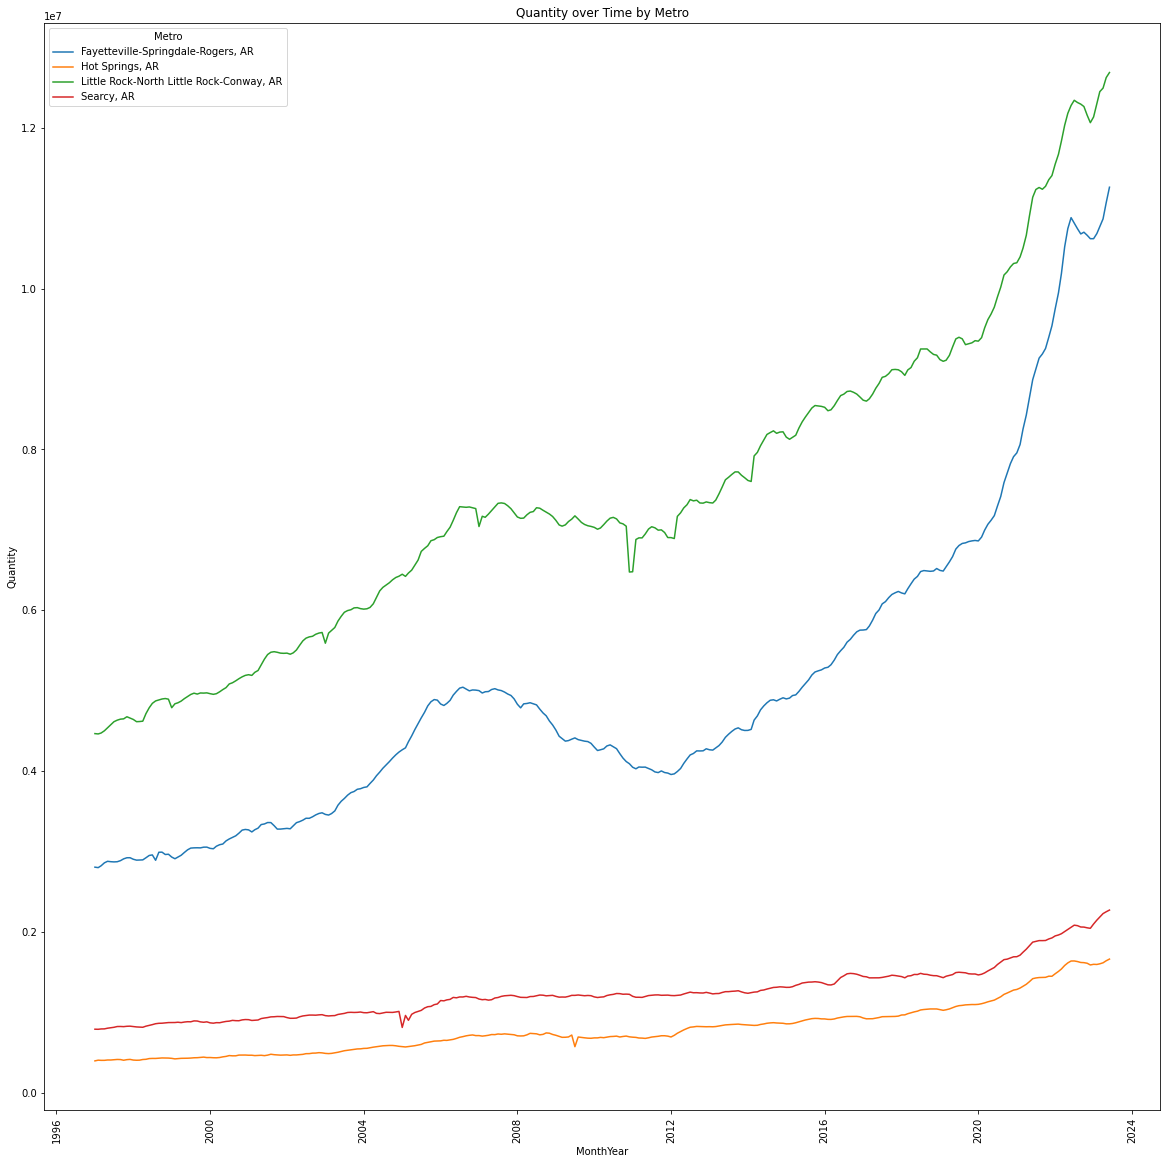

In [26]:
lineplot_data = AR_timeseries_data.groupby(['MonthYear', 'Metro'])[['Quantity']].sum().reset_index()

pyplot.figure(figsize = (20,20))
seaborn.lineplot(x = lineplot_data['MonthYear'], y = lineplot_data['Quantity'], hue = lineplot_data['Metro'])
pyplot.title('Quantity over Time by Metro')
pyplot.xticks(rotation = 'vertical')
pyplot.show()

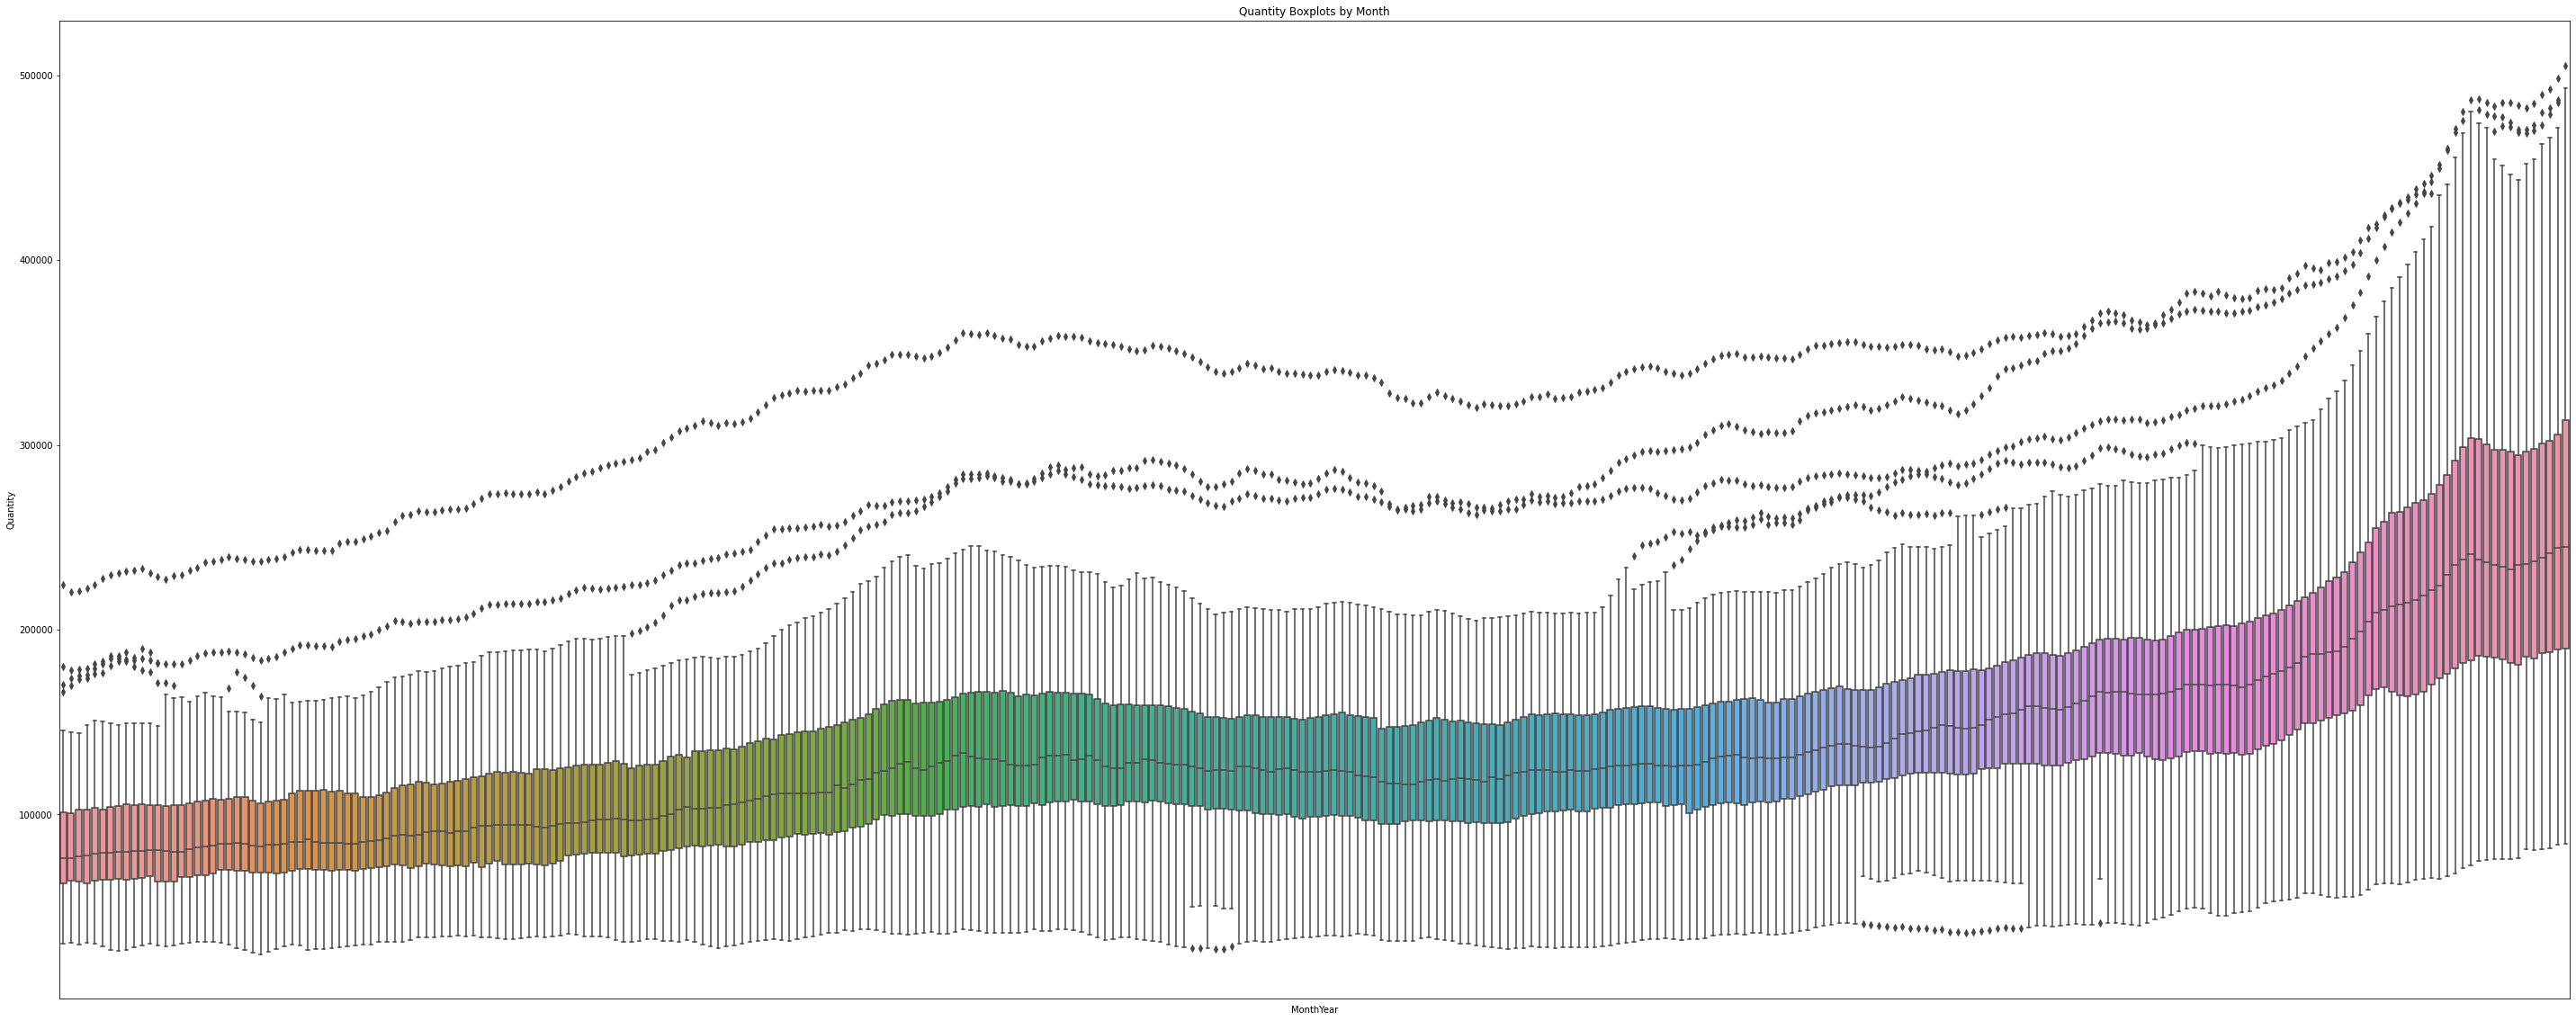

In [27]:
pyplot.figure(figsize = (50,20))
seaborn.boxplot(x = AR_timeseries_data['MonthYear'], y = AR_timeseries_data['Quantity'])
pyplot.title('Quantity Boxplots by Month')
pyplot.xticks([])
pyplot.show()

Great! Now, we will create a couple more visuals, one by year and one by metro area.

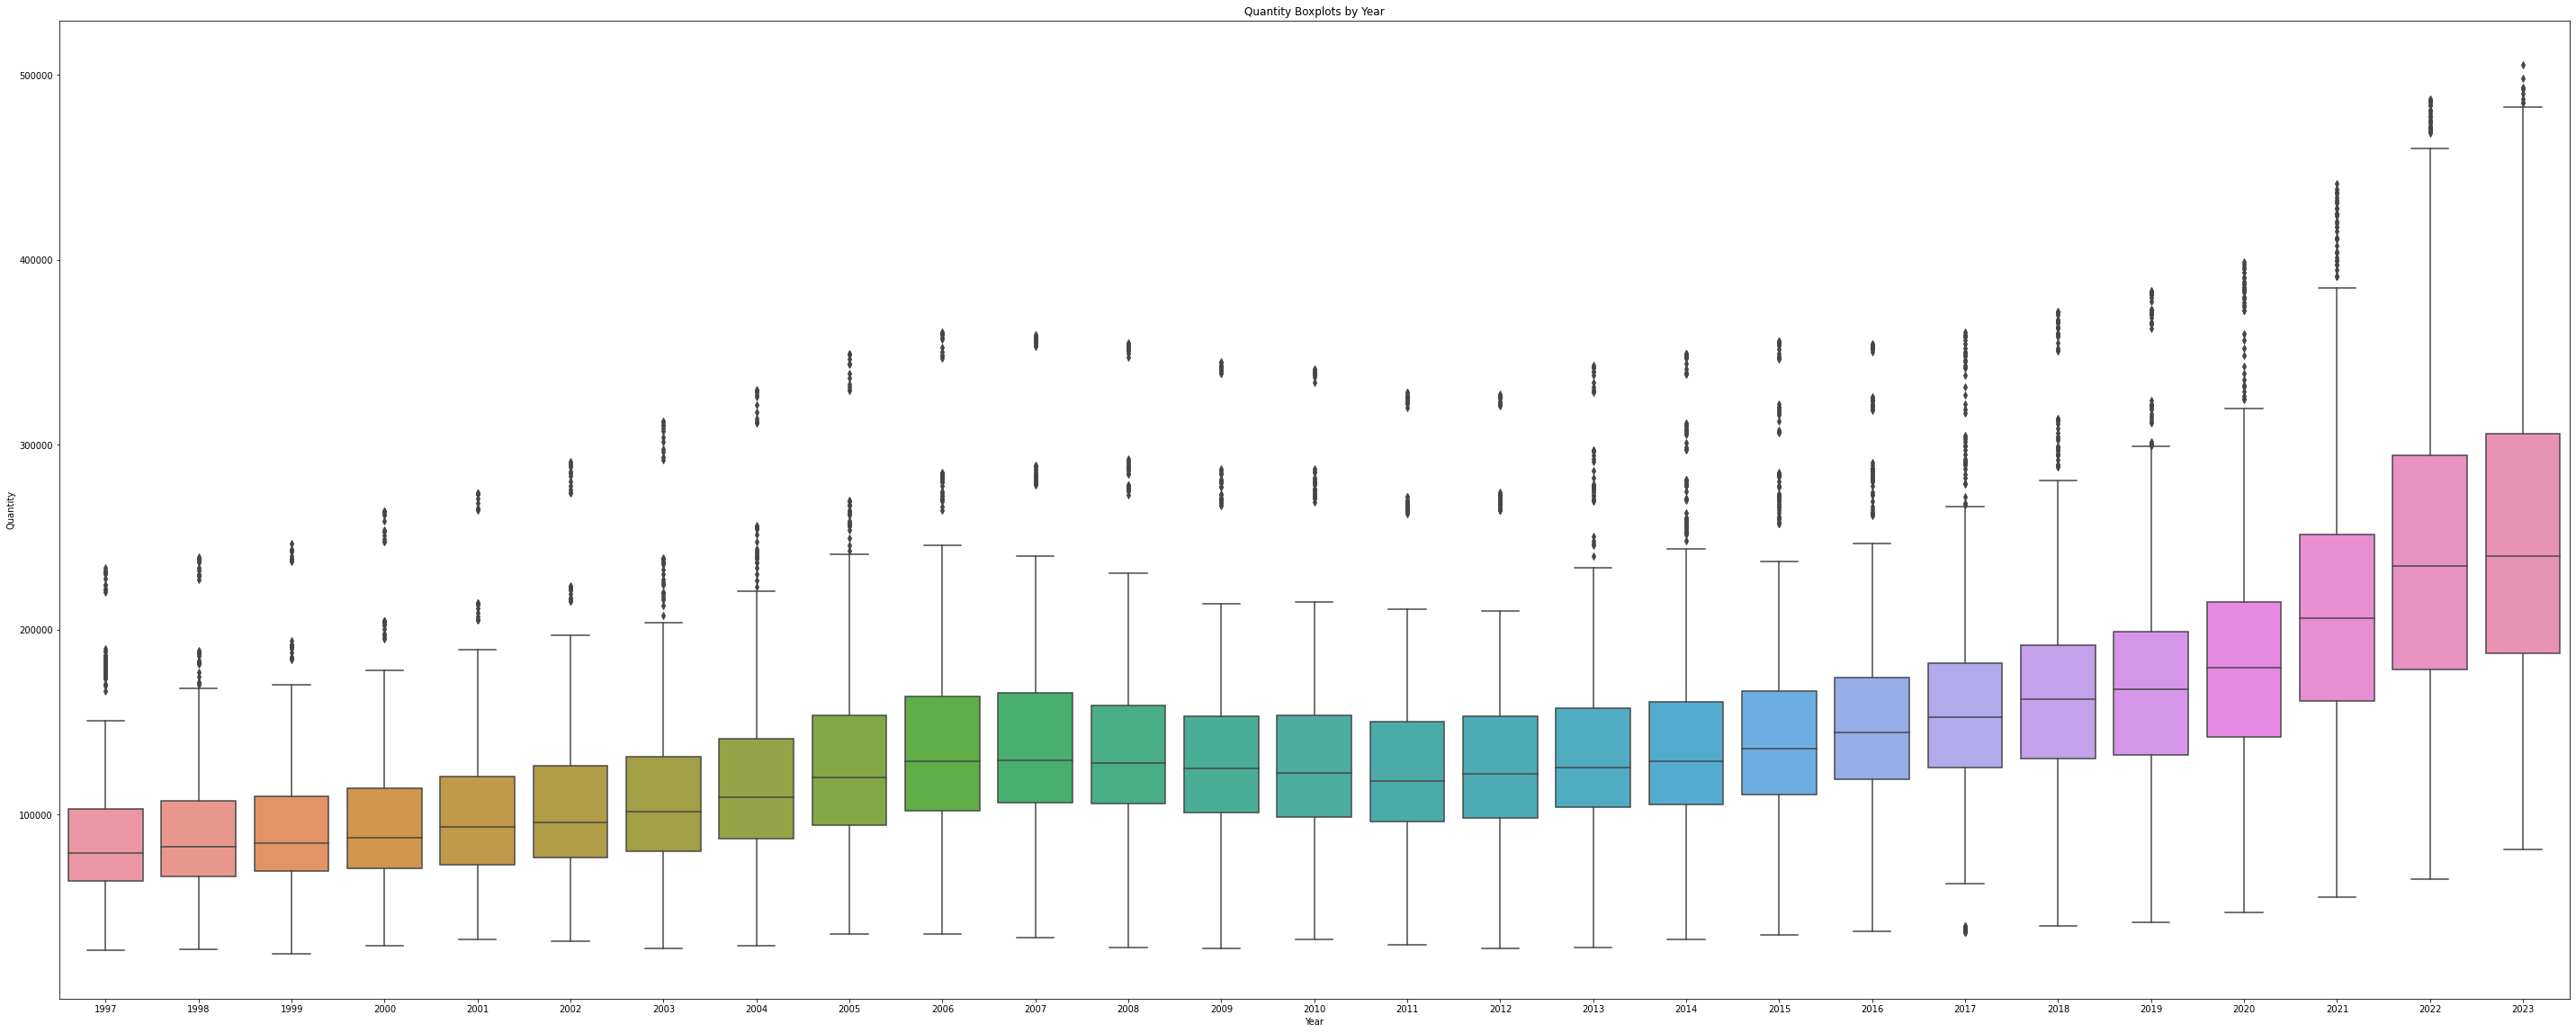

In [28]:
pyplot.figure(figsize = (50,20))
seaborn.boxplot(x = AR_timeseries_data['YearString'], y = AR_timeseries_data['Quantity'])
pyplot.title('Quantity Boxplots by Year')
pyplot.xlabel('Year')
pyplot.show()

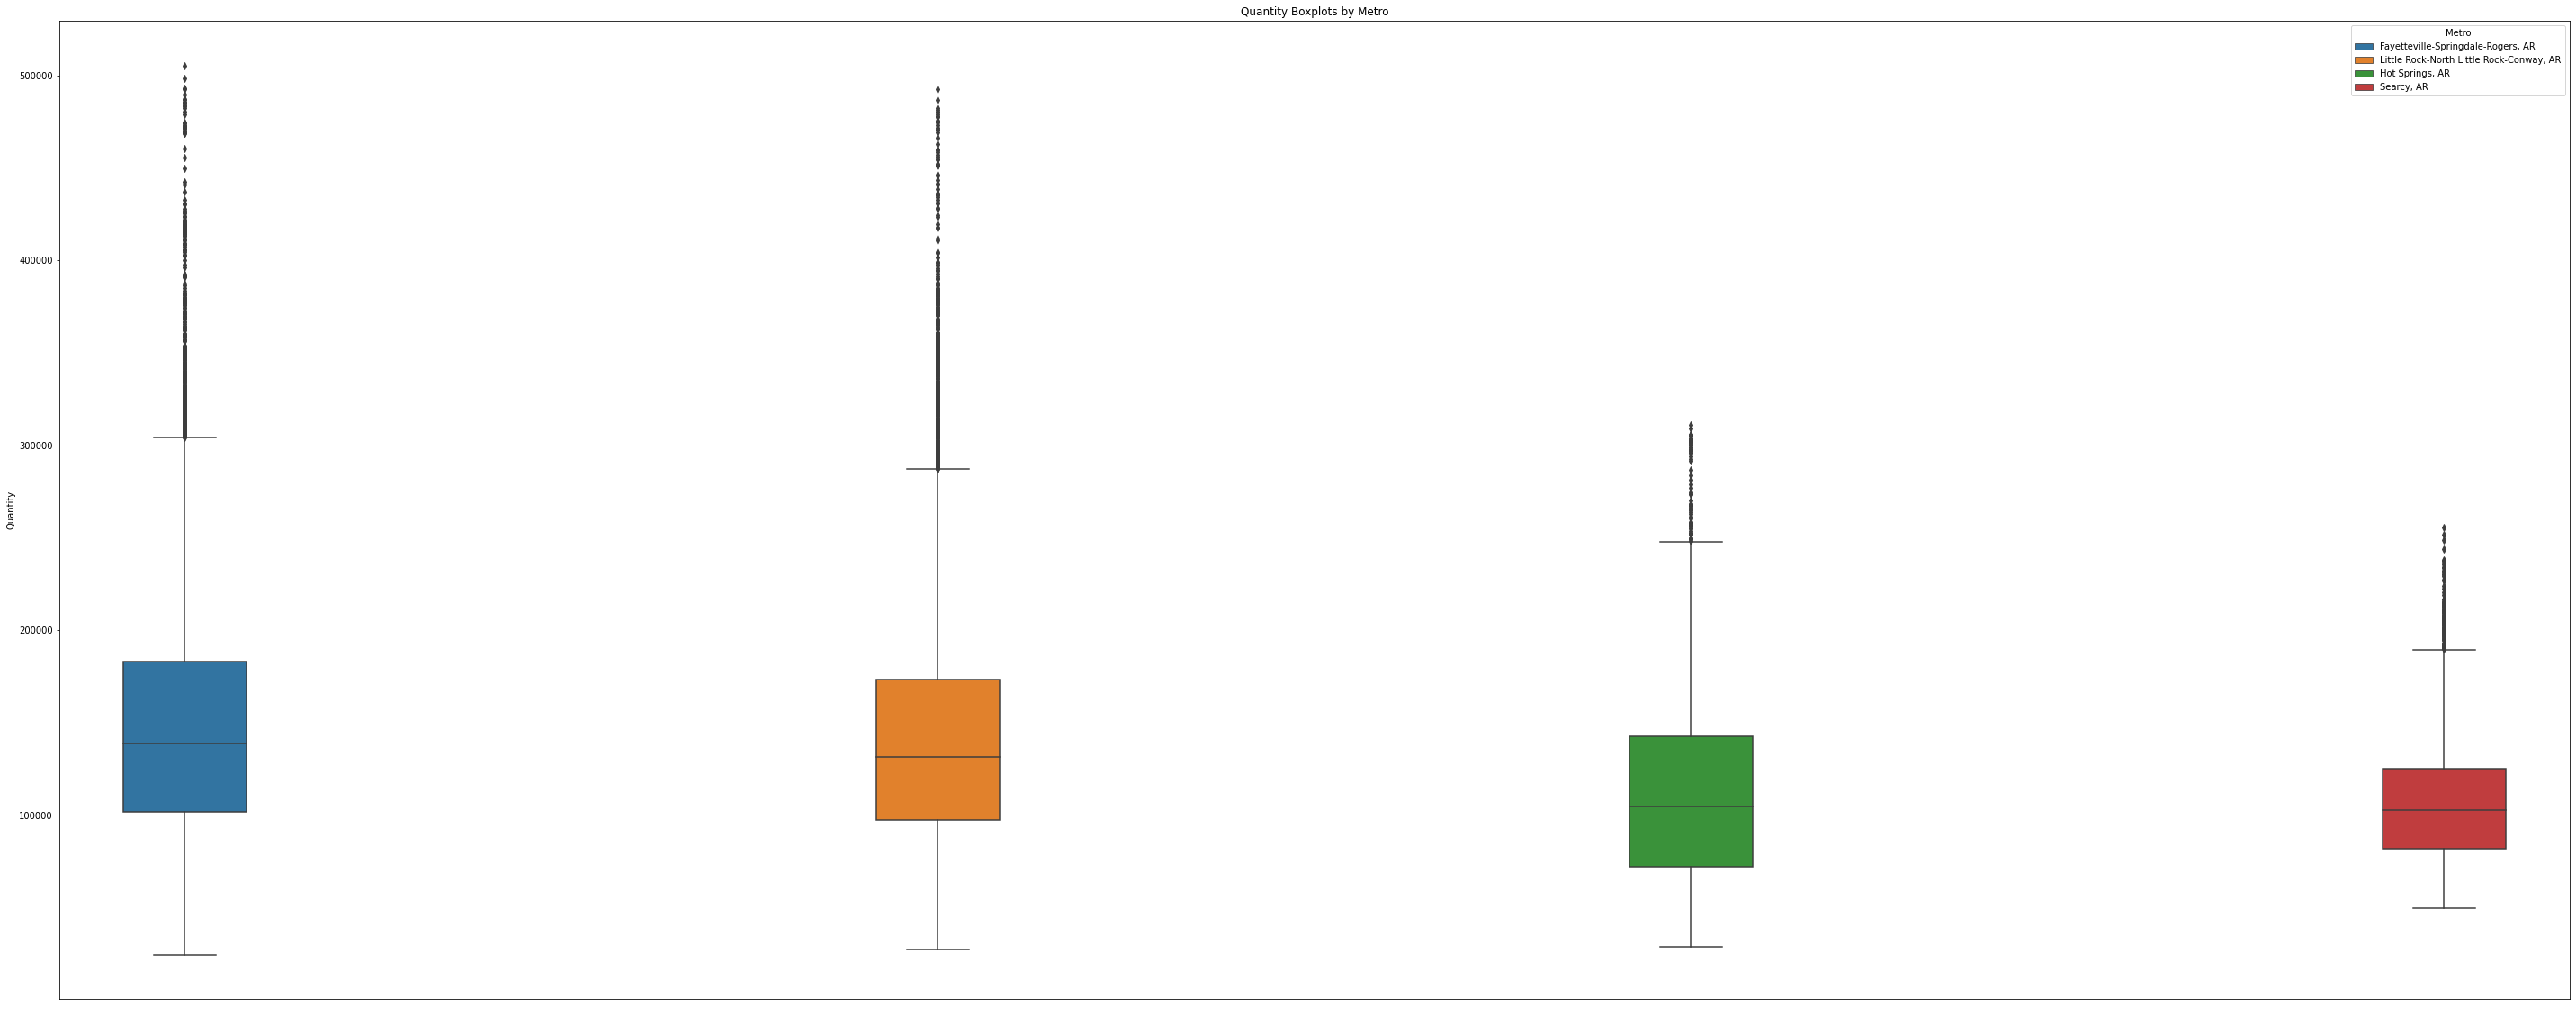

In [29]:
pyplot.figure(figsize = (50,20))
seaborn.boxplot(x = AR_timeseries_data['Metro'], y = AR_timeseries_data['Quantity'], hue = AR_timeseries_data['Metro'])
pyplot.title('Quantity Boxplots by Metro')
pyplot.xlabel('')
pyplot.xticks([])
pyplot.show()

Now, it is time to do some time series modeling using ARIMA models. Before doing this, we will need to look for Autocorrelation, Partial Autocorrelation, and the p-value of the ADF test to see whether data are stationary.

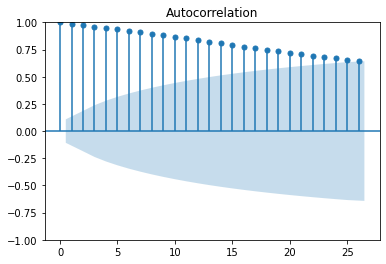

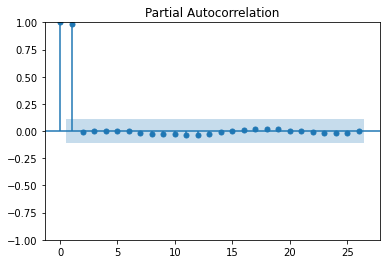

ADF TEST:
P-Value: 0.9666907387416679
CAN NOT CONCLUDE THAT THE DATA ARE NOT NON-STATIONARY.
DIFFERENCING IS NEEDED.


In [30]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller

agg_data = data.groupby('MonthYear')[['Quantity']].sum()
agg_data = agg_data.sort_index()

plot_acf(agg_data['Quantity'], ax = pyplot.gca())
pyplot.show()

plot_pacf(agg_data['Quantity'], ax = pyplot.gca())
pyplot.show()

adf = adfuller(agg_data['Quantity'], autolag = 'AIC')
print('ADF TEST:')
print('P-Value:',  adf[1])
if adf[1] >= 0.5: print('CAN NOT CONCLUDE THAT THE DATA ARE NOT NON-STATIONARY.\nDIFFERENCING IS NEEDED.')
else: print('CAN CONCLUDE THAT THE DATA ARE NOT NON-STATIONARY.\nDIFFERENCING NOT NEEDED.')

These results show that differencing will be needed before using the data in ARIMA models. This will be incorporated at a later time.

One more test to look at before using this time series data will be to ensure that data are available from each year from start to finish.

In [31]:
print('Distinct Years in Data')
years = list(set(data['YearString']))
years.sort()
for year in years: print(year)

Distinct Years in Data
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


Looks great! Time for ARIMA!!

ARIMA Modeling can get complex, and we want to use it many times in the lab activity, so a function will be created to reduce code redundancy. The function will create visualizations and return a DataFrame will resulting forecasts by month. Function parameters will include input data, training data start year, training data end year, testing data start year, testing data end year, the option to add an additional condition to subset the input data, the field name in the input data for the month, the field name in the input data for the quantity to forecast, and whether to apply differencing before ARIMA modeling.

In [32]:
def monthly_forecast_comparison(data, train_start_year, train_end_year, forecast_start_year, forecast_end_year = None, condition = None, month_field = 'Month', forecast_field = 'Quantity', diff = False):
    
    #imports
    import datetime
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

    #Set forecast_end_year
    if forecast_end_year == None: forecast_end_year = forecast_start_year

    #set training and testing start and end dates
    train_start_date = datetime.date(year = train_start_year, month = 1, day = 1)
    train_end_date = datetime.date(year = train_end_year, month = 12, day = 31)
    test_start_date = datetime.date(year = forecast_start_year, month = 1, day = 1)
    test_end_date = datetime.date(year = forecast_end_year, month = 12, day = 31)

    #TRAINING DATA
    #for additional condition
    try:
        cond_field = condition.split('=')[0].strip()
        cond_val = condition.split('=')[1].strip()
        try: cond_val = int(cond_val)
        except: pass
        train = data[(data[month_field] >= train_start_date) & (data[month_field] <= train_end_date) & (data[cond_field] == cond_val)].set_index(month_field)
    except:
        if condition != None:
            print('Condition did not match required format of "(field name) = (field_value)" using either string or integer fields.')
            print('No other types of conditions are enabled at this time.')
            print('Please consider passing in a DataFrame that already meets this condition.')
        else:
            train = data[(data[month_field] >= train_start_date) & (data[month_field] <= train_end_date)].set_index(month_field)
    
    train.index = pandas.DatetimeIndex(train.index, freq = 'infer').to_period('M')
    train = train[[forecast_field]].groupby(train.index).sum()
    train = train.sort_index()

    #Difference train data
    if diff: train_diff = pandas.DataFrame(train.diff())
    else: train_diff = pandas.DataFrame(train)
    

    #TESTING DATA
    #for additional condition
    try:
        cond_field = condition.split('=')[0].strip()
        cond_val = condition.split('=')[1].strip()
        try: cond_val = int(cond_val)
        except: pass
        test = data[(data[month_field] >= test_start_date) & (data[month_field] <= test_end_date) & (data[cond_field] == cond_val)].set_index(month_field)
    except:
        if condition == None:
            test = data[(data[month_field] >= test_start_date) & (data[month_field] <= test_end_date)].set_index(month_field)
    
    test.index = pandas.DatetimeIndex(test.index, freq = 'infer').to_period('M')
    test = test[[forecast_field]].groupby(test.index).sum()
    test = test.sort_index()



    #Lists for model and loops
    train_list = list(train_diff[forecast_field])
    forecasts = []
    iterations = len(test)

    #Iterate through models to create forecasts
    for iter in range(iterations):
        
        #Initialize model
        if diff: model = ARIMA(train_list, order = (2,1,0))
        else: model = ARIMA(train_list, order = (2,0,0))

        #Train model
        fitted_model = model.fit()

        #Find next forecasted value and append that to train and forecasts lists
        if diff: forecast = fitted_model.forecast()[0] + train_list[-1]
        else: forecast = fitted_model.forecast()[0]
        forecasts.append(forecast)
        train_list.append(fitted_model.forecast()[0])

    
    #Add forecasts to test data and create some comparison columns
    test['Forecast'] = forecasts
    test['Actual_-_Forecast'] = test[forecast_field] - test['Forecast']
    test['%_Error'] = test['Actual_-_Forecast'].abs() / test[forecast_field]


    #Create visualization
    visual_data_actuals = pandas.concat([train[forecast_field].to_frame(), test[forecast_field].to_frame()])
    visual_data_actuals.index = visual_data_actuals.index.to_timestamp()
    test.index = test.index.to_timestamp()
    
    from matplotlib import pyplot
    import seaborn

    #set figure size
    pyplot.figure(figsize = (10,10))

    seaborn.lineplot(x = visual_data_actuals.index, y = visual_data_actuals[forecast_field], color = 'blue')
    seaborn.lineplot(x = test.index, y = test['Forecast'], color = 'orange')

    #Title with condition if applicable
    try:
        condition.split('=')
        pyplot.title('Monthly ' + forecast_field + ' Actuals (Blue) and Forecast (Orange) Where ' + condition)
    except:
        pyplot.title('Monthly ' + forecast_field + ' Actuals (Blue) and Forecast (Orange)')

    pyplot.xlabel('')
    pyplot.ylabel('')
    pyplot.show()


    #Return test DataFrame
    return(test)

Now, we will use the function with a few different combinations of function parameters.

Forecasting 2023 (No Differencing)

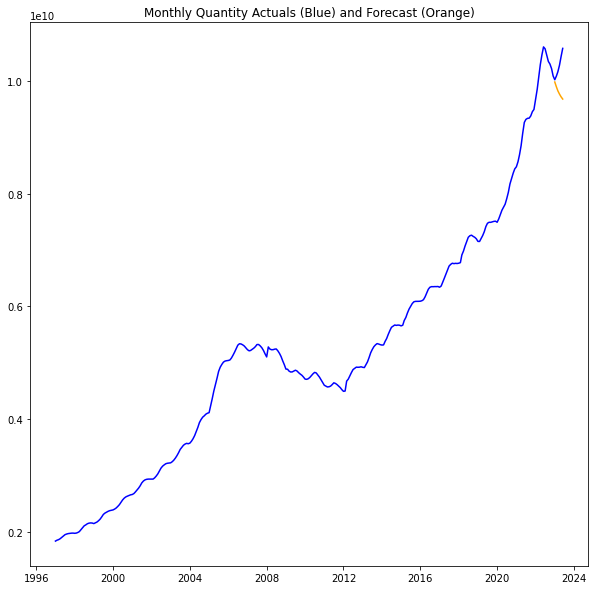

,Quantity,Forecast,Actual_-_Forecast,%_Error
MonthYear,,,,
2023-01-01,1.002030e+10,9.980470e+09,3.983037e+07,0.003975
2023-02-01,1.008633e+10,9.893724e+09,1.926014e+08,0.019095
2023-03-01,1.016224e+10,9.822845e+09,3.393997e+08,0.033398
2023-04-01,1.027946e+10,9.764772e+09,5.146879e+08,0.050070
2023-05-01,1.043132e+10,9.717027e+09,7.142898e+08,0.068476
2023-06-01,1.057695e+10,9.677605e+09,8.993469e+08,0.085029


In [33]:
monthly_forecast_comparison(data = data, month_field = 'MonthYear', forecast_field = 'Quantity', train_start_year = 1997, train_end_year = 2022, forecast_start_year = 2023)

Forecasting 2023 (with Differencing)

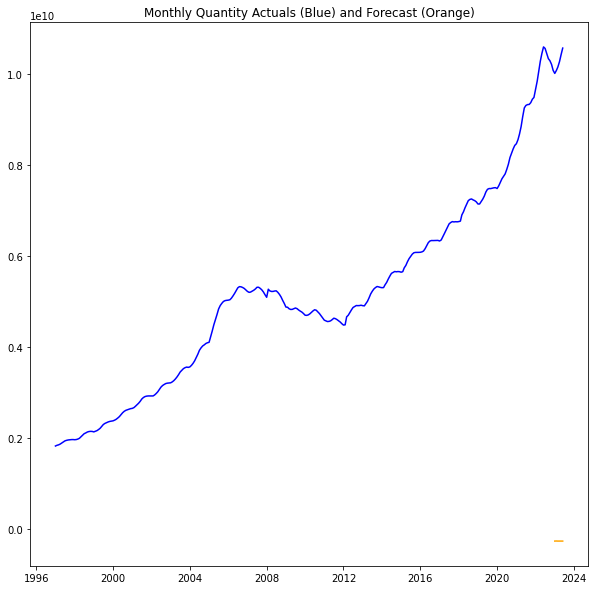

,Quantity,Forecast,Actual_-_Forecast,%_Error
MonthYear,,,,
2023-01-01,1.002030e+10,-2.574539e+08,1.027775e+10,1.025693
2023-02-01,1.008633e+10,-2.557822e+08,1.034211e+10,1.025359
2023-03-01,1.016224e+10,-2.577124e+08,1.041996e+10,1.025360
2023-04-01,1.027946e+10,-2.574383e+08,1.053690e+10,1.025044
2023-05-01,1.043132e+10,-2.575425e+08,1.068886e+10,1.024689
2023-06-01,1.057695e+10,-2.575206e+08,1.083447e+10,1.024347


In [34]:
monthly_forecast_comparison(data = data, month_field = 'MonthYear', forecast_field = 'Quantity', train_start_year = 1997, train_end_year = 2022, forecast_start_year = 2023, diff = True)

Forecasting Arkansas for 2023 (with Differencing)

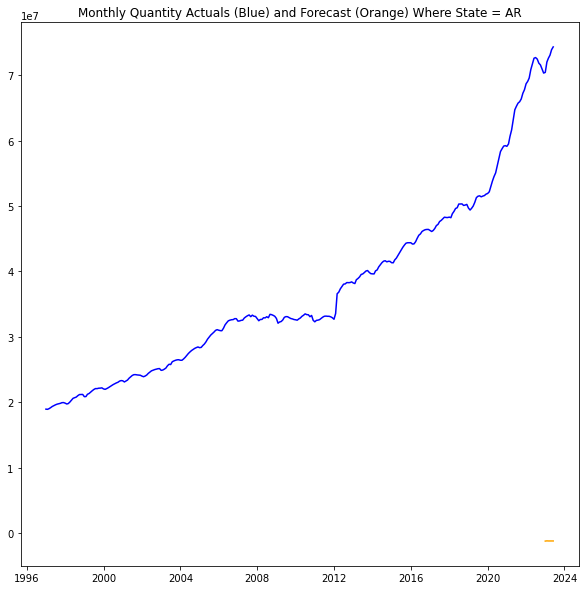

,Quantity,Forecast,Actual_-_Forecast,%_Error
MonthYear,,,,
2023-01-01,7.041111e+07,-1.199443e+06,7.161056e+07,1.017035
2023-02-01,7.199622e+07,-1.163595e+06,7.315981e+07,1.016162
2023-03-01,7.256695e+07,-1.181295e+06,7.374824e+07,1.016279
2023-04-01,7.304469e+07,-1.180402e+06,7.422509e+07,1.016160
2023-05-01,7.387509e+07,-1.178252e+06,7.505334e+07,1.015949
2023-06-01,7.430330e+07,-1.179085e+06,7.548239e+07,1.015869


In [35]:
monthly_forecast_comparison(data = data, condition = 'State = AR', month_field = 'MonthYear', forecast_field = 'Quantity', train_start_year = 1997, train_end_year = 2022, forecast_start_year = 2023, diff = True)

Forecasting Arkansas for 2016 to 2023 (with Differencing)

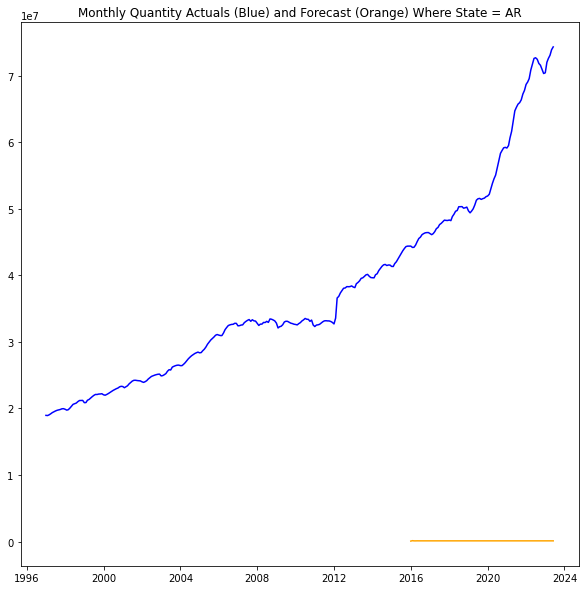

,Quantity,Forecast,Actual_-_Forecast,%_Error
MonthYear,,,,
2016-01-01,4.438374e+07,75853.941409,4.430788e+07,0.998291
2016-02-01,4.418415e+07,138996.447323,4.404516e+07,0.996854
2016-03-01,4.420261e+07,109689.884821,4.409292e+07,0.997518
2016-04-01,4.453767e+07,107787.180646,4.442988e+07,0.997580
2016-05-01,4.505734e+07,115364.132371,4.494197e+07,0.997440
...,...,...,...,...
2023-02-01,7.199622e+07,112609.336522,7.188361e+07,0.998436
2023-03-01,7.256695e+07,112609.336522,7.245434e+07,0.998448
2023-04-01,7.304469e+07,112609.336522,7.293208e+07,0.998458


In [36]:
monthly_forecast_comparison(data = data, condition = 'State = AR', month_field = 'MonthYear', forecast_field = 'Quantity', train_start_year = 1997, train_end_year = 2015, \
    forecast_start_year = 2016, forecast_end_year = 2023, diff = True)

Forecasting Arkansas for 2023 (No Differencing)

c:\Users\nvidetti\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


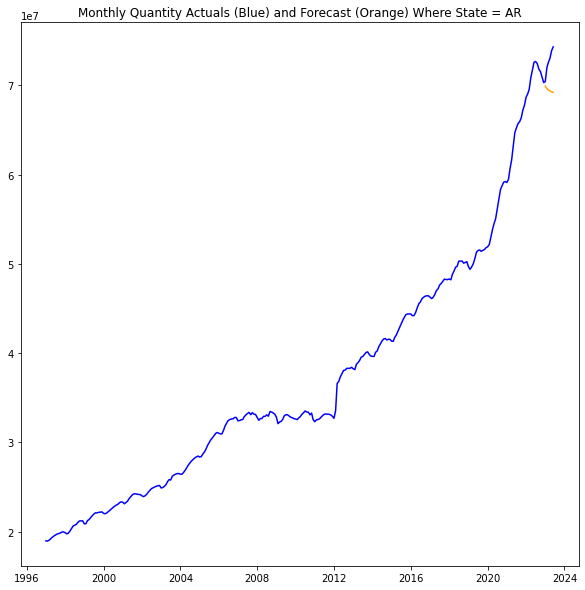

,Quantity,Forecast,Actual_-_Forecast,%_Error
MonthYear,,,,
2023-01-01,7.041111e+07,6.990406e+07,5.070527e+05,0.007201
2023-02-01,7.199622e+07,6.964193e+07,2.354291e+06,0.032700
2023-03-01,7.256695e+07,6.946902e+07,3.097925e+06,0.042691
2023-04-01,7.304469e+07,6.935301e+07,3.691682e+06,0.050540
2023-05-01,7.387509e+07,6.927314e+07,4.601955e+06,0.062294
2023-06-01,7.430330e+07,6.921622e+07,5.087084e+06,0.068464


In [37]:
monthly_forecast_comparison(data = data, condition = 'State = AR', month_field = 'MonthYear', forecast_field = 'Quantity', train_start_year = 1997, train_end_year = 2022, forecast_start_year = 2023)

Forecasting 2016 to 2023 (No Differencing)

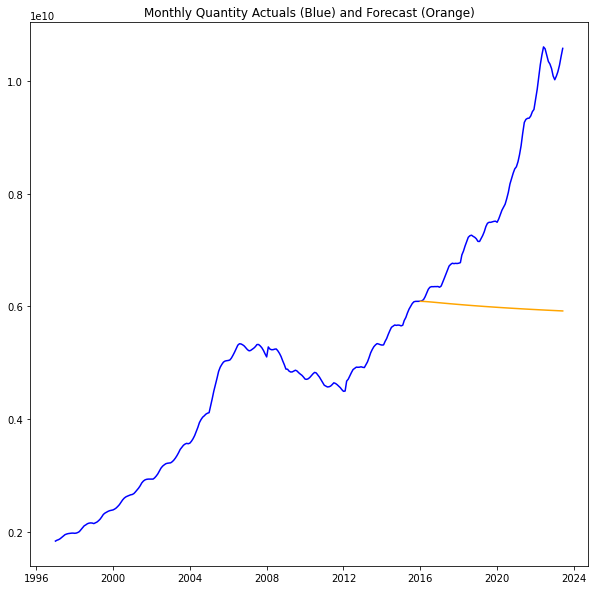

,Quantity,Forecast,Actual_-_Forecast,%_Error
MonthYear,,,,
2016-01-01,6.089420e+09,6.087619e+09,1.801300e+06,0.000296
2016-02-01,6.098498e+09,6.086938e+09,1.156081e+07,0.001896
2016-03-01,6.116345e+09,6.085650e+09,3.069440e+07,0.005018
2016-04-01,6.167490e+09,6.083929e+09,8.356105e+07,0.013549
2016-05-01,6.233474e+09,6.081902e+09,1.515726e+08,0.024316
...,...,...,...,...
2023-02-01,1.008633e+10,5.922181e+09,4.164144e+09,0.412850
2023-03-01,1.016224e+10,5.920841e+09,4.241404e+09,0.417369
2023-04-01,1.027946e+10,5.919511e+09,4.359949e+09,0.424142


In [38]:
monthly_forecast_comparison(data = data, month_field = 'MonthYear', forecast_field = 'Quantity', train_start_year = 1997, train_end_year = 2015, forecast_start_year = 2016, forecast_end_year = 2023)

Interesting results for sure. It seems that not differencing results in much better forecasting, even though data were not found to be stationary.

Now, it is time to look at data by Zip Code and year. First, we will need to aggregate into a separate DataFrame and display the resulting DataFrame.

In [39]:
zip_by_year = data.groupby(['Year', 'ZipCode'])[['Quantity']].median()
zip_by_year['Year'] = [index[0] for index in zip_by_year.index]
zip_by_year['ZipCode'] = [index[1] for index in zip_by_year.index]
zip_by_year = zip_by_year.set_index('Year')

zip_by_year

,Quantity,ZipCode
Year,,
1996-01-01,126721.814337,01001
1996-01-01,190749.152280,01002
1996-01-01,126679.111595,01005
1996-01-01,156185.979411,01007
1996-01-01,118562.770220,01008
...,...,...
2023-01-01,291008.364218,99827
2023-01-01,309530.532848,99833
2023-01-01,555501.547998,99835


Looks great! Next, we will create another functon very similar to the previously created one, but slighly simpler. This function will aggregate by year and zip code. It will also only let you foreacast out a single year. Also, quantites will be aggregated as median rather than sum. Visualizations will not be generated, but a DataFrame with results will still be returned. Function parameters will include input data, training data start year, training data end year, year to forecast, the option to add an additional condition to subset the input data, the field name in the input data for the year, the field name in the input data for the quantity to forecast, and whether to apply differencing before ARIMA modeling.

In [40]:
def forecast_year_zipcode_rank(data, train_start_year, train_end_year, forecast_year, condition = None, year_field = 'Year', forecast_field = 'Quantity', diff = False):
    
    #imports
    import warnings
    import datetime
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

    #Silence warnings
    warnings.filterwarnings("ignore")

    #set training and testing start and end dates
    train_start_date = datetime.date(year = train_start_year, month = 1, day = 1)
    train_end_date = datetime.date(year = train_end_year, month = 1, day = 1)
    test_date = datetime.date(year = forecast_year, month = 1, day = 1)

    #TRAINING DATA
    #for additional condition
    try:
        cond_field = condition.split('=')[0].strip()
        cond_val = condition.split('=')[1].strip()
        try: cond_val = int(cond_val)
        except: pass
        train = data[(data[year_field] >= train_start_date) & (data[year_field] <= train_end_date) & (data[cond_field] == cond_val)].set_index(year_field)
    except:
        if condition != None:
            print('Condition did not match required format of "(field name) = (field_value)" using either string or integer fields.')
            print('No other types of conditions are enabled at this time.')
            print('Please consider passing in a DataFrame that already meets this condition.')
        else:
            train = data[(data[year_field] >= train_start_date) & (data[year_field] <= train_end_date)].set_index(year_field)
    
    train.index = pandas.DatetimeIndex(train.index, freq = 'infer').to_period('Y')
    train = train[['ZipCode', forecast_field]].groupby([train.index, 'ZipCode']).median()
    train['Year'] = [index[0] for index in train.index]
    train['ZipCode'] = [index[1] for index in train.index]
    train = train.set_index('Year')
    train = train.sort_index()
    

    
    #TESTING DATA
    #for additional condition
    try:
        cond_field = condition.split('=')[0].strip()
        cond_val = condition.split('=')[1].strip()
        try: cond_val = int(cond_val)
        except: pass
        test = data[(data[year_field] == test_date) & (data[cond_field] == cond_val)].set_index(year_field)
    except:
        if condition == None:
            test = data[data[year_field] == test_date].set_index(year_field)
    
    test.index = pandas.DatetimeIndex(test.index, freq = 'infer').to_period('Y')
    test = test[['ZipCode', forecast_field]].groupby([test.index, 'ZipCode']).median()
    test['Year'] = [index[0] for index in test.index]
    test['ZipCode'] = [index[1] for index in test.index]
    test = test.set_index('Year')
    test = test.sort_index()
    


    zip_codes = list(set([str(zip) for zip in train['ZipCode']]))
    forecasts = []
    for zip in zip_codes:

        #Difference train data
        if diff: train_list = list(train[train['ZipCode'] == zip][[forecast_field]].diff()[forecast_field])
        else: train_list = list(train[train['ZipCode'] == zip][forecast_field])

        #Initialize model
        if diff: model = ARIMA(train_list, order = (2,1,0), trend = 't')
        else: model = ARIMA(train_list, order = (2,0,0), trend = 't')

        #Train model
        fitted_model = model.fit()

        #Find next forecasted value and append that to train and forecasts lists
        if diff: forecast = fitted_model.forecast()[0] + train_list[-1]
        else: forecast = fitted_model.forecast()[0]
        forecasts.append([zip, forecast])
        train_list.append([zip, fitted_model.forecast()[0]])

    zip_forecasts = pandas.DataFrame(forecasts, columns = ['ZipCode', 'Forecast'])

    return_data = test.merge(zip_forecasts, on = 'ZipCode').sort_values('Forecast')
    
    #Add forecasts to test data and create some comparison columns
    return_data['Actual_-_Forecast'] = return_data[forecast_field] - return_data['Forecast']
    return_data['%_Error'] = return_data['Actual_-_Forecast'].abs() / return_data[forecast_field]
    return_data['Forecast_Rank_ASC'] = [i+1 for i in range(len(return_data))]
    return_data['Forecast_Rank_DESC'] = [len(return_data) - j for j in range(len(return_data))]

    return_data = return_data.set_index('ZipCode')

    #Reset warnings
    warnings.resetwarnings()

    #Return test DataFrame
    return(return_data)

Now, we will run this function using a few different combinations of function parameters.

Forecasting New York Zip Codes for 2023 (with Differencing)

In [41]:
forecast_year_zipcode_rank(data, train_start_year = 1997, train_end_year = 2022, forecast_year = 2023, year_field = 'Year', forecast_field = 'Quantity', diff = True, \
    condition = 'State = NY')

,Quantity,Forecast,Actual_-_Forecast,%_Error,Forecast_Rank_ASC,Forecast_Rank_DESC
ZipCode,,,,,,
10018,9.556224e+05,-9.973012e+05,1.952924e+06,2.043614,1,1670
10004,9.574123e+05,-9.347852e+05,1.892197e+06,1.976366,2,1669
10012,3.067839e+06,-8.338115e+05,3.901651e+06,1.271791,3,1668
10001,1.340325e+06,-5.240972e+05,1.864422e+06,1.391023,4,1667
10006,7.841770e+05,-4.049052e+05,1.189082e+06,1.516344,5,1666
...,...,...,...,...,...,...
10065,6.041031e+06,1.293475e+06,4.747556e+06,0.785885,1666,5
10014,5.437706e+06,1.309887e+06,4.127819e+06,0.759110,1667,4
11932,4.601484e+06,1.349241e+06,3.252242e+06,0.706781,1668,3


Forecasting New York Zip Codes for 2023 (No Differencing)

In [42]:
forecast_year_zipcode_rank(data, train_start_year = 1997, train_end_year = 2022, forecast_year = 2023, year_field = 'Year', forecast_field = 'Quantity', diff = False, \
    condition = 'State = NY')

,Quantity,Forecast,Actual_-_Forecast,%_Error,Forecast_Rank_ASC,Forecast_Rank_DESC
ZipCode,,,,,,
13666,5.414846e+04,6.378466e+04,-9636.206731,0.177959,1,1670
14707,5.708829e+04,6.967501e+04,-12586.712265,0.220478,2,1669
14774,6.763783e+04,7.868741e+04,-11049.586072,0.163364,3,1668
10038,7.667426e+05,8.017462e+04,686567.965239,0.895435,4,1667
14605,7.335092e+04,8.073758e+04,-7386.662308,0.100703,5,1666
...,...,...,...,...,...,...
10013,4.863440e+06,5.180422e+06,-316982.135461,0.065177,1666,5
11976,5.159350e+06,5.559935e+06,-400584.319835,0.077642,1667,4
10065,6.041031e+06,6.064005e+06,-22974.003607,0.003803,1668,3


Once again, not consistently great results. Also once again, differencing results in much worse forecasting than no differencing. The remainder of the analyses in the lab will include differencing since it is suggested based on results of Autocorrelation, Partial Autocorrelation, and the p-value of the ADF test, but it is seen that results will likely not be terribly accurate.

First, we will look at New York State Zip Codes. The resulting DataFrame from the previously created function will need to be joined with the main combined DataFrame for geospatial data, as the results of the best and worst Zip Codes will be graphed.

In [43]:
zip_forecast_2023_NY = forecast_year_zipcode_rank(data, train_start_year = 1996, train_end_year = 2022, forecast_year = 2023, year_field = 'Year', forecast_field = 'Quantity', diff = True, \
    condition = 'State = NY')

zip_forecast_2023_NY = zip_forecast_2023_NY.merge(data[['ZipCode', 'Latitude', 'Longitude']], left_index = True, right_on = 'ZipCode').set_index('ZipCode').drop_duplicates()

zip_forecast_2023_NY

,Quantity,Forecast,Actual_-_Forecast,%_Error,Forecast_Rank_ASC,Forecast_Rank_DESC,Latitude,Longitude
ZipCode,,,,,,,,
10018,9.556224e+05,-9.973012e+05,1.952924e+06,2.043614,1,1670,40.755319,-73.993114
10004,9.574123e+05,-9.347852e+05,1.892197e+06,1.976366,2,1669,40.688630,-74.018244
10012,3.067839e+06,-8.338115e+05,3.901651e+06,1.271791,3,1668,40.725581,-73.998078
10001,1.340325e+06,-5.240972e+05,1.864422e+06,1.391023,4,1667,40.750633,-73.997177
10006,7.841770e+05,-4.049052e+05,1.189082e+06,1.516344,5,1666,40.709614,-74.012954
...,...,...,...,...,...,...,...,...
10065,6.041031e+06,1.309039e+06,4.731992e+06,0.783309,1666,5,40.764612,-73.963122
10014,5.437706e+06,1.309887e+06,4.127819e+06,0.759110,1667,4,40.734012,-74.006746
11932,4.601484e+06,1.356165e+06,3.245318e+06,0.705277,1668,3,40.934313,-72.306615


One more step to take first is bringing in some data to plot borders and give a better idea as to where in the state these Zip Codes actually are. These data are far from complete, but still have most of the borders for each state.

In [44]:
border_path = tkinter.filedialog.askopenfile(title = 'Please Choose State Borders Data File...').name
border_data = pandas.read_json(border_path)

border_data.head()

C:\Users\nvidetti\AppData\Local\Temp\ipykernel_14008\1890960911.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:/Users/nvidetti/Downloads/State_Borders_Data.json' mode='r' encoding='cp1252'>
  border_path = tkinter.filedialog.askopenfile(title = 'Please Choose State Borders Data File...').name


,type,features
0,FeatureCollection,"{'type': 'Feature', 'id': 'AL', 'properties': ..."
1,FeatureCollection,"{'type': 'Feature', 'id': 'AK', 'properties': ..."
2,FeatureCollection,"{'type': 'Feature', 'id': 'AZ', 'properties': ..."
3,FeatureCollection,"{'type': 'Feature', 'id': 'AR', 'properties': ..."
4,FeatureCollection,"{'type': 'Feature', 'id': 'CA', 'properties': ..."


In [45]:
border_data['State'] = [feature['id'] for feature in border_data['features']]
border_data['Coordinates'] = [feature['geometry']['coordinates'] for feature in border_data['features']]
border_data = border_data.drop(columns = ['type', 'features'])

while 1 == 1:
    rows = len(border_data)
    exploded = border_data.explode('Coordinates')
    types = list(set([type(row) for row in exploded]))

    if rows == len(exploded) and len(types) == 1 and types[0] == str: break
    else: 
        border_data = pandas.DataFrame(exploded)

border_data = border_data.reset_index(drop = True)
border_data['Latitude'] = [border_data['Coordinates'][index] if index % 2 == 1 else 0 for index in border_data.index]
border_data['Longitude'] = [border_data['Coordinates'][index] if index % 2 == 0 else 0 for index in border_data.index]
border_data['Index'] = [index - 1 if index % 2 == 1 else index for index in border_data.index]
border_data = border_data.drop(columns = ['Coordinates']).groupby(['Index', 'State']).sum()
border_data['State'] = [index[1] for index in border_data.index]
border_data = border_data.reset_index(drop = True)

border_data

,Latitude,Longitude,State
0,35.001180,-87.359296,AL
1,34.984749,-85.606675,AL
2,34.124869,-85.431413,AL
3,32.859696,-85.184951,AL
4,32.580372,-85.069935,AL
...,...,...,...
3512,40.998429,-111.047063,WY
3513,42.000709,-111.047063,WY
3514,44.476286,-111.047063,WY
3515,45.002073,-111.052540,WY


These data needed to be cleaned and unstacked, but we now have some good quality data. Let's graph the results to see how much of the borders we have.

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

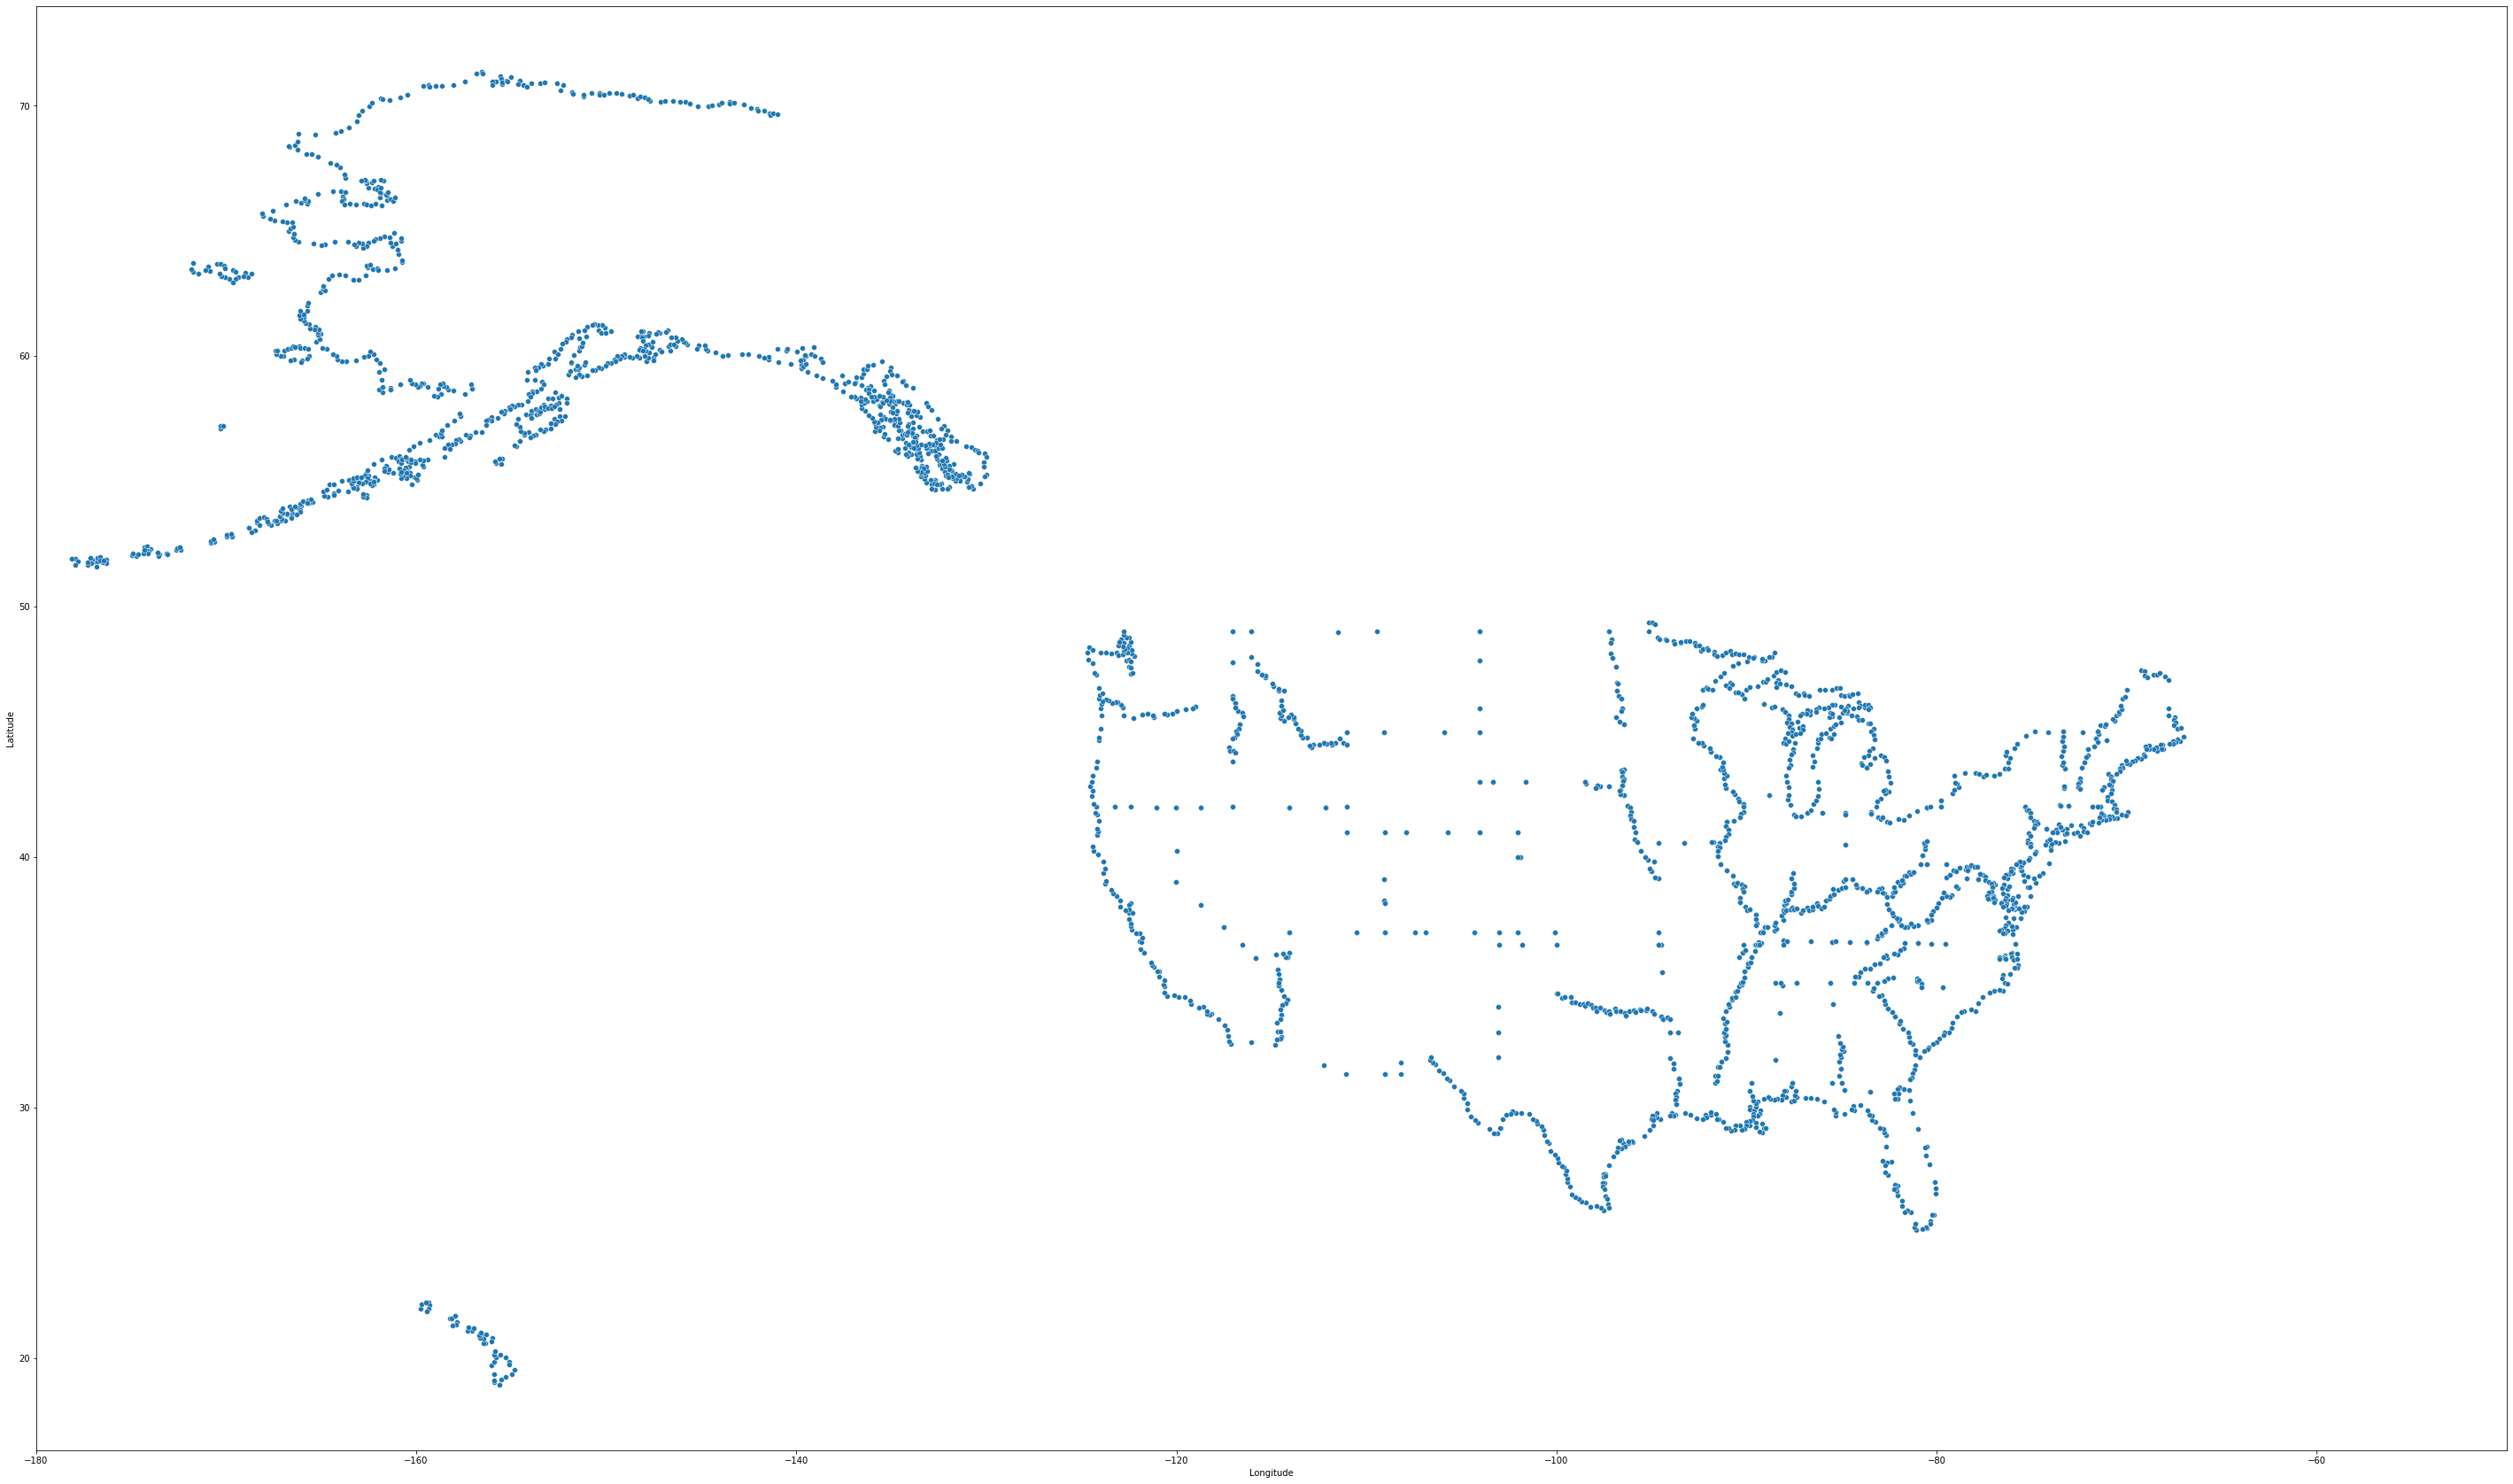

In [46]:
pyplot.figure(figsize = (50,30))
pyplot.xlim(-180,-50)
seaborn.scatterplot(x = border_data['Longitude'], y = border_data['Latitude'])

Okay, well it could be better... But it does the trick for some states, so we will make sure to keep our analysis to those states.

As promissed, here are the results for New York Zip Codes! First, this will show the top forecasted Zip Code.

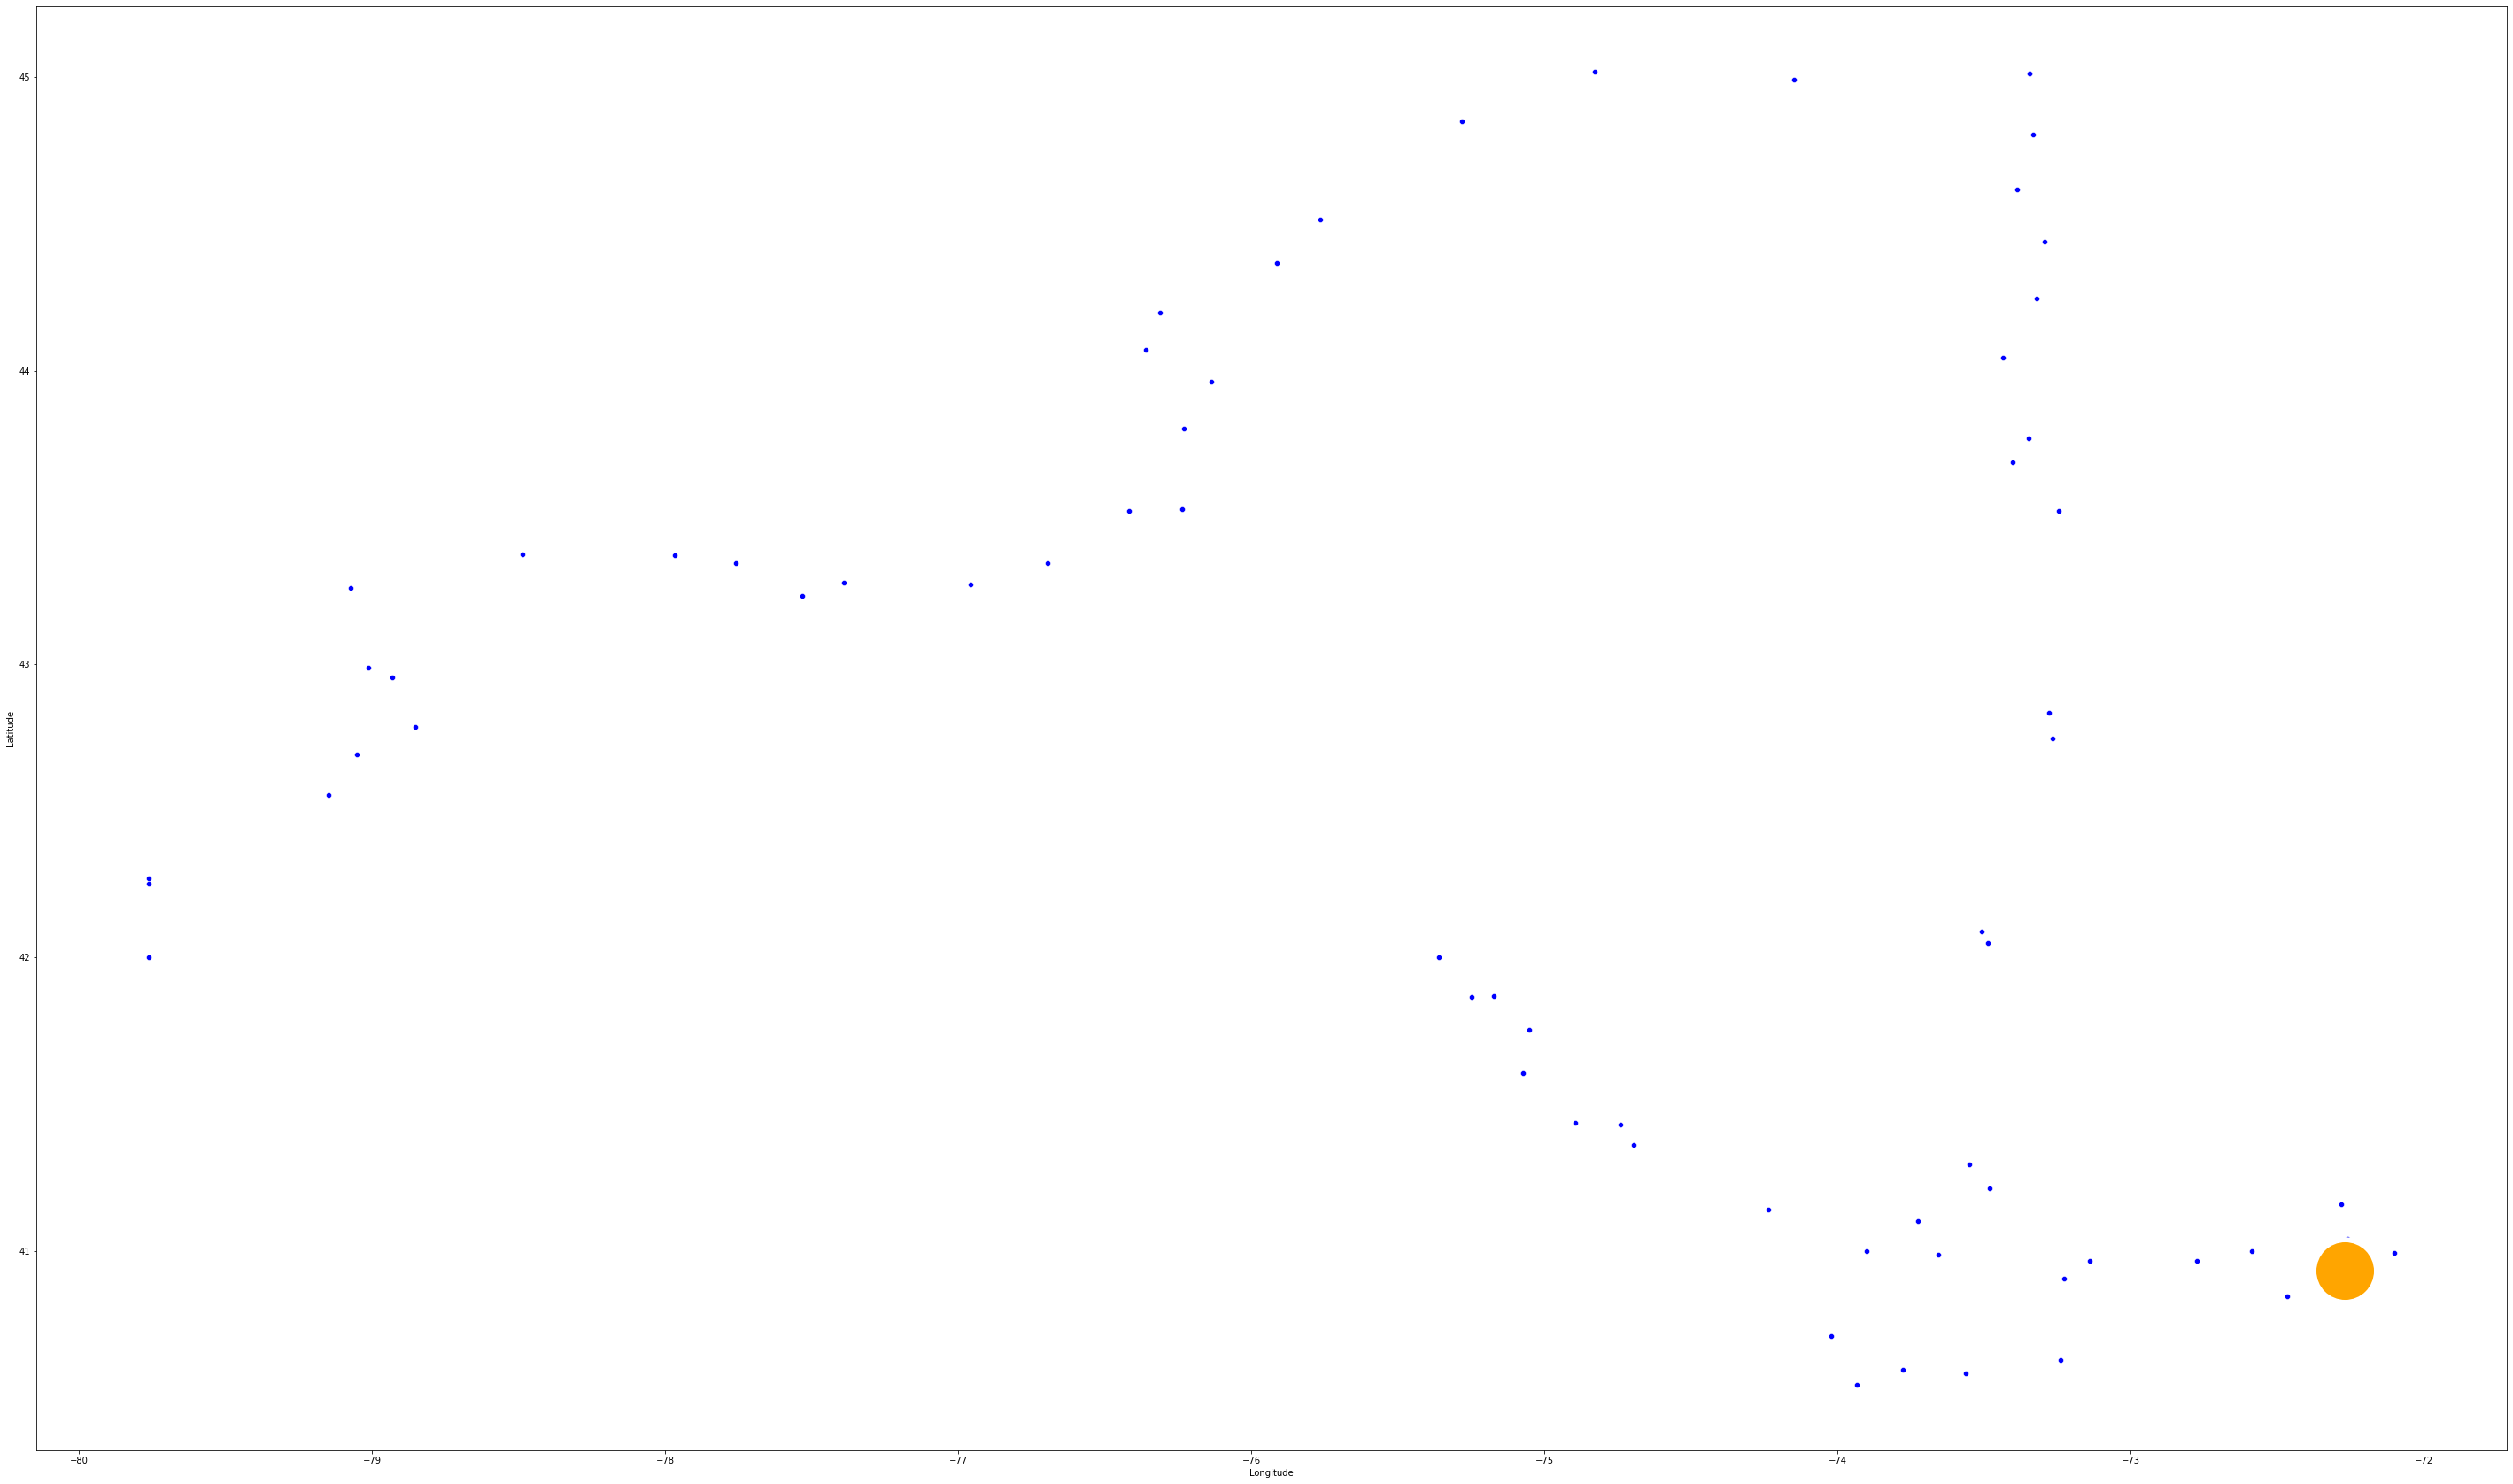

In [47]:
pyplot.figure(figsize = (50,30))
#pyplot.xlim(-180,-50)
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')

map_point = zip_forecast_2023_NY[zip_forecast_2023_NY['Forecast_Rank_DESC'] == 1][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 5000)

pyplot.show()


And now for full analysis...

Top Forecasted Zip Codes in New York for 2023

Top Zip Code in New York


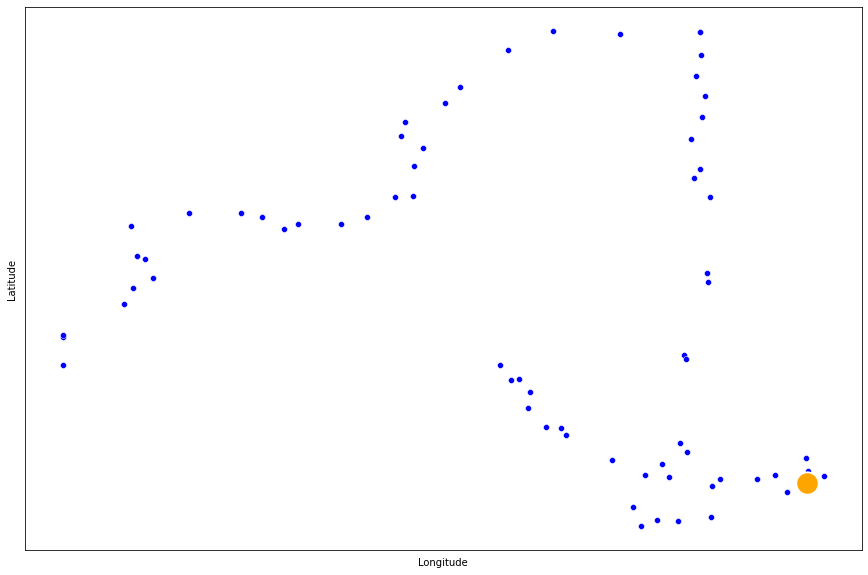

Top 3 Zip Codes in New York


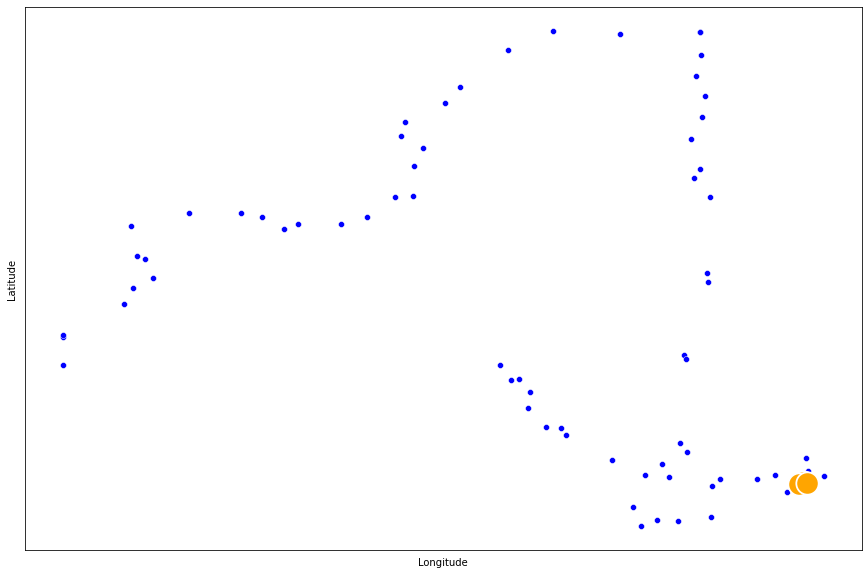

Top 20 Zip Codes in New York


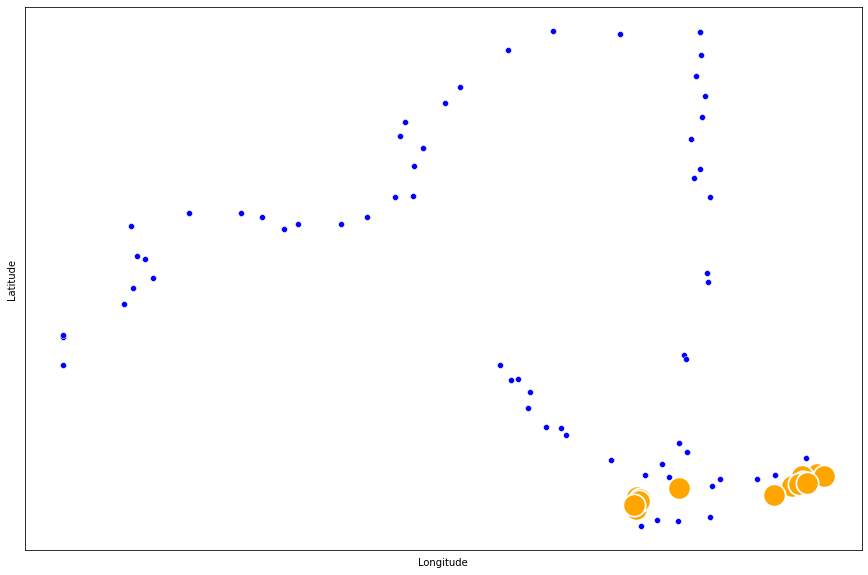

Top 100 Zip Codes in New York


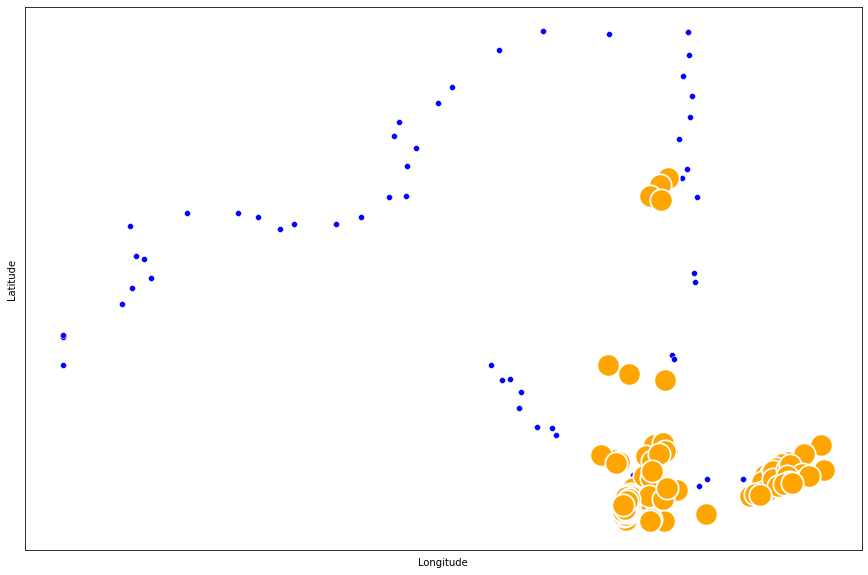

In [48]:
print('Top Zip Code in New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_NY[zip_forecast_2023_NY['Forecast_Rank_DESC'] == 1][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Top 3 Zip Codes in New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_NY[(zip_forecast_2023_NY['Forecast_Rank_DESC'] >= 1) & (zip_forecast_2023_NY['Forecast_Rank_DESC'] <= 3)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Top 20 Zip Codes in New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_NY[(zip_forecast_2023_NY['Forecast_Rank_DESC'] >= 1) & (zip_forecast_2023_NY['Forecast_Rank_DESC'] <= 20)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Top 100 Zip Codes in New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_NY[(zip_forecast_2023_NY['Forecast_Rank_DESC'] >= 1) & (zip_forecast_2023_NY['Forecast_Rank_DESC'] <= 100)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

Bottom Forecasted Zip Codes in New York for 2023

Bottom Zip Code in New York


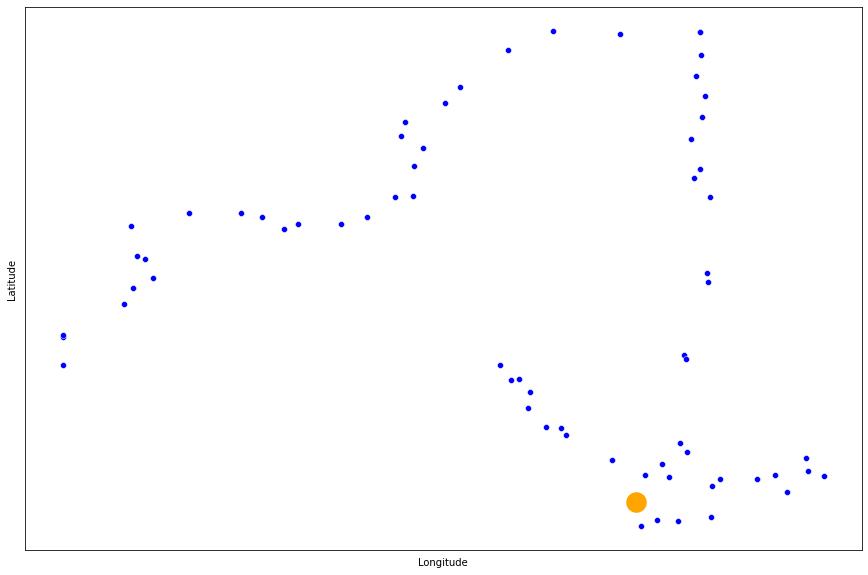

Bottom 3 Zip Codes in New York


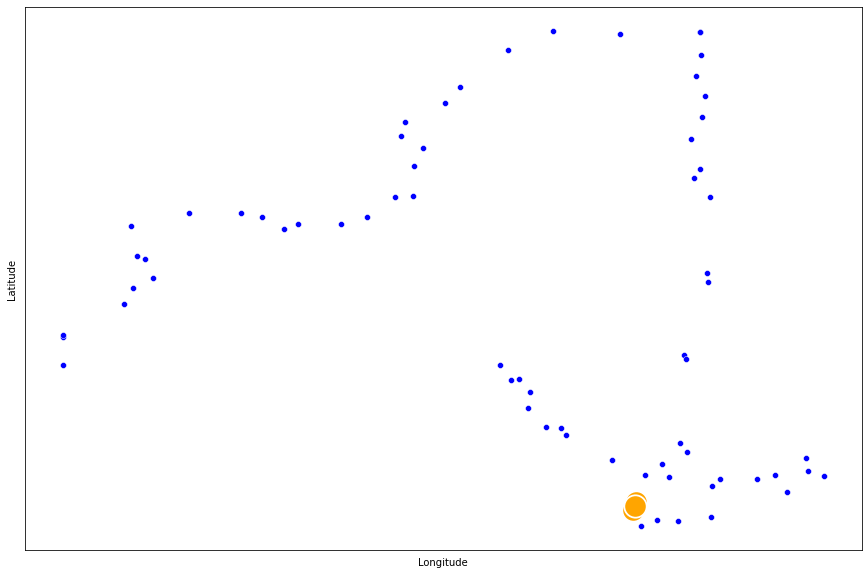

Bottom 20 Zip Codes in New York


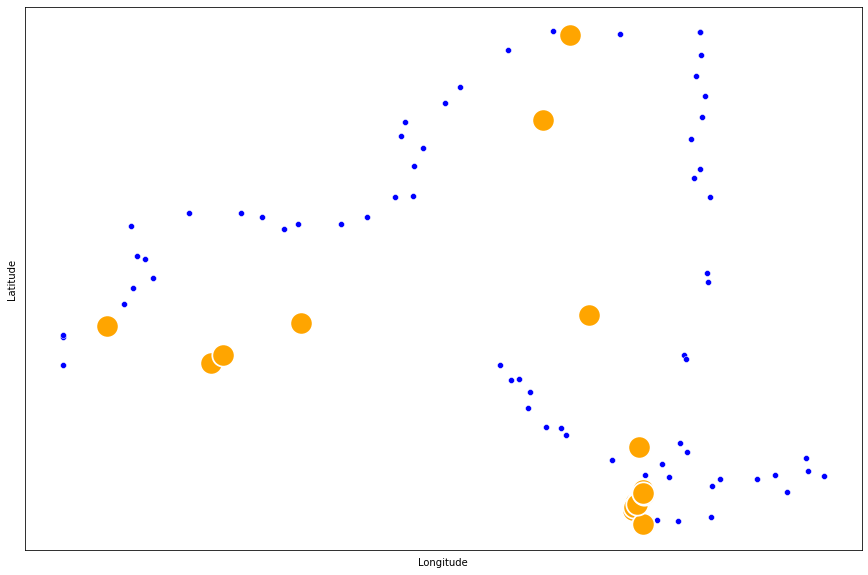

Bottom 100 Zip Codes in New York


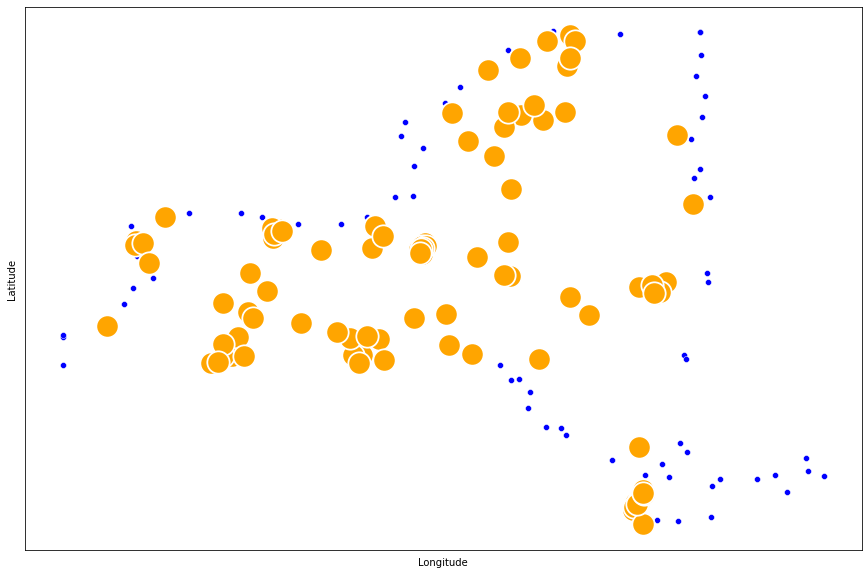

In [49]:
print('Bottom Zip Code in New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_NY[zip_forecast_2023_NY['Forecast_Rank_ASC'] == 1][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Bottom 3 Zip Codes in New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_NY[(zip_forecast_2023_NY['Forecast_Rank_ASC'] >= 1) & (zip_forecast_2023_NY['Forecast_Rank_ASC'] <= 3)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Bottom 20 Zip Codes in New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_NY[(zip_forecast_2023_NY['Forecast_Rank_ASC'] >= 1) & (zip_forecast_2023_NY['Forecast_Rank_ASC'] <= 20)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Bottom 100 Zip Codes in New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_NY[(zip_forecast_2023_NY['Forecast_Rank_ASC'] >= 1) & (zip_forecast_2023_NY['Forecast_Rank_ASC'] <= 100)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

Florida Analysis

In [50]:
zip_forecast_2023_FL = forecast_year_zipcode_rank(data, train_start_year = 1996, train_end_year = 2022, forecast_year = 2023, year_field = 'Year', forecast_field = 'Quantity', diff = True, \
    condition = 'State = FL')

zip_forecast_2023_FL = zip_forecast_2023_FL.merge(data[['ZipCode', 'Latitude', 'Longitude']], left_index = True, right_on = 'ZipCode').set_index('ZipCode').drop_duplicates()

zip_forecast_2023_FL

,Quantity,Forecast,Actual_-_Forecast,%_Error,Forecast_Rank_ASC,Forecast_Rank_DESC,Latitude,Longitude
ZipCode,,,,,,,,
33854,9.309854e+04,2.153022e+04,7.156831e+04,0.768737,1,935,27.856440,-81.410106
32064,1.606886e+05,2.328266e+04,1.374060e+05,0.855107,2,934,30.295625,-82.984108
32187,2.475594e+05,2.885643e+04,2.187030e+05,0.883436,3,933,29.578946,-81.550038
32305,1.805896e+05,3.026194e+04,1.503276e+05,0.832427,4,932,30.332299,-84.300654
32310,1.768226e+05,3.474478e+04,1.420778e+05,0.803505,5,931,30.385436,-84.512181
...,...,...,...,...,...,...,...,...
33921,4.248363e+06,2.461827e+06,1.786536e+06,0.420523,931,5,26.772225,-82.252804
33149,4.444099e+06,2.502783e+06,1.941316e+06,0.436830,932,4,25.719513,-80.168541
33139,4.273594e+06,3.070822e+06,1.202773e+06,0.281443,933,3,25.779808,-80.153200


Top Forecasted Zip Codes in Florida for 2023

Top Zip Code in Florida


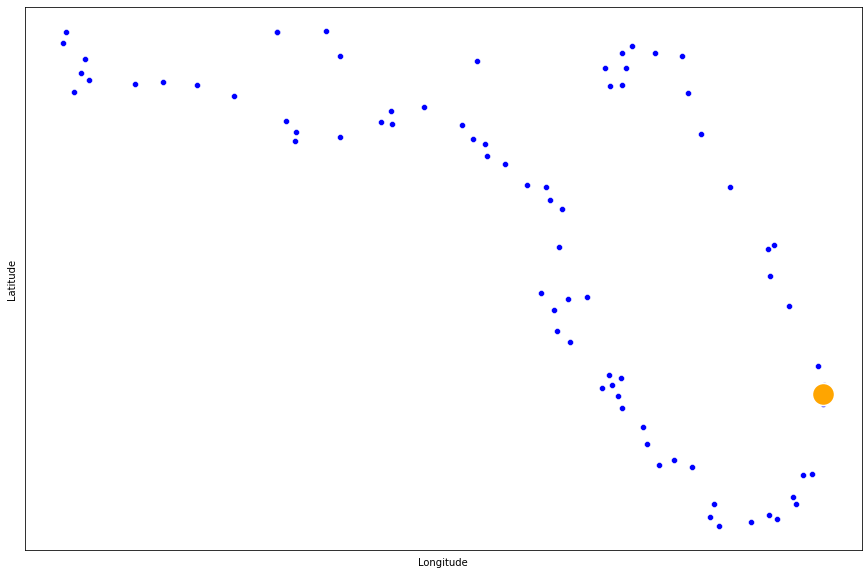

Top 3 Zip Codes in Florida


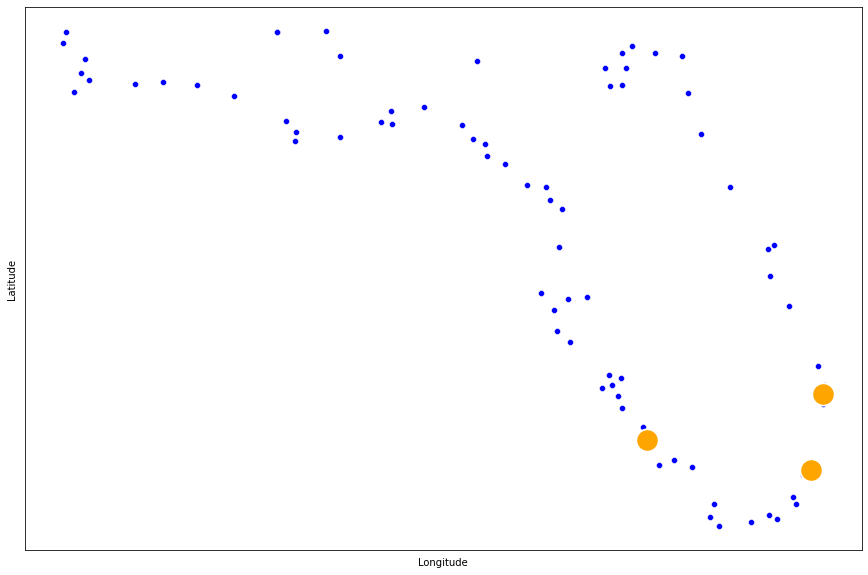

Top 20 Zip Codes in Florida


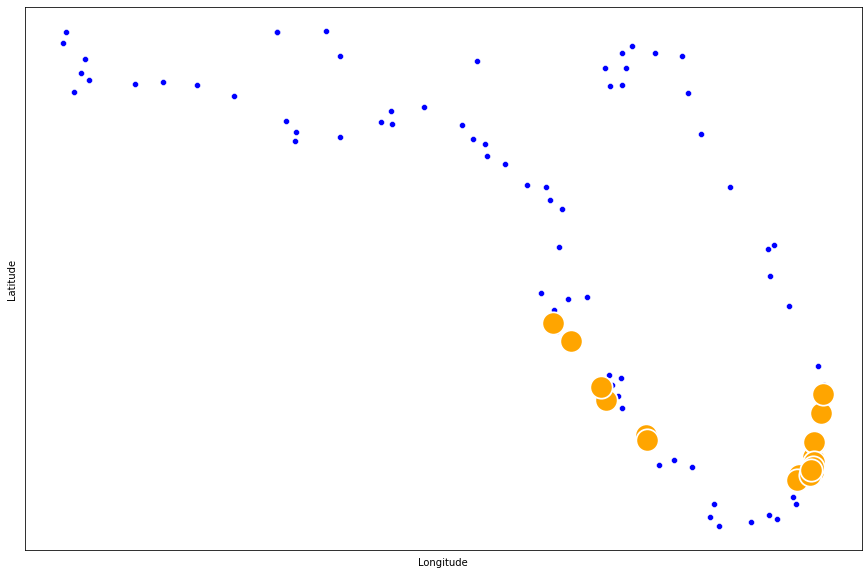

Top 100 Zip Codes in Florida


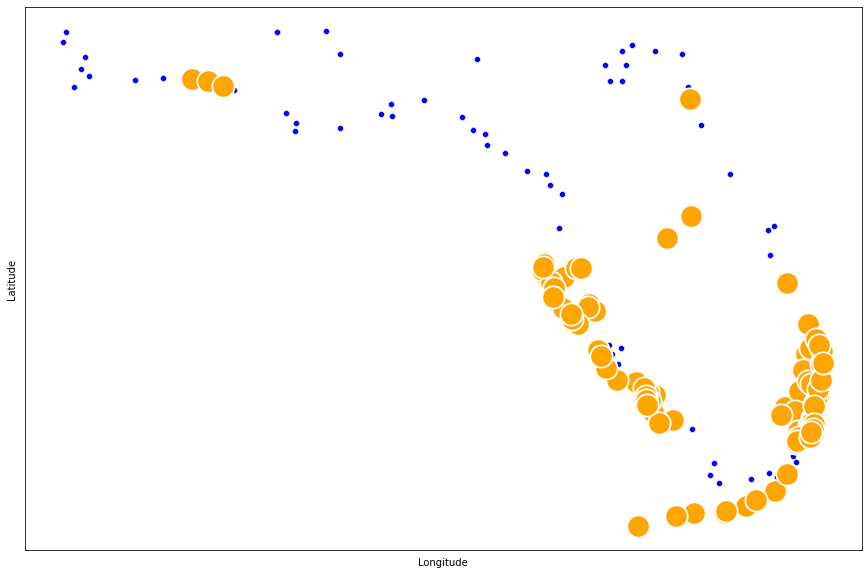

In [51]:
print('Top Zip Code in Florida')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'FL'], color = 'blue')
map_point = zip_forecast_2023_FL[zip_forecast_2023_FL['Forecast_Rank_DESC'] == 1][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Top 3 Zip Codes in Florida')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'FL'], color = 'blue')
map_point = zip_forecast_2023_FL[(zip_forecast_2023_FL['Forecast_Rank_DESC'] >= 1) & (zip_forecast_2023_FL['Forecast_Rank_DESC'] <= 3)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Top 20 Zip Codes in Florida')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'FL'], color = 'blue')
map_point = zip_forecast_2023_FL[(zip_forecast_2023_FL['Forecast_Rank_DESC'] >= 1) & (zip_forecast_2023_FL['Forecast_Rank_DESC'] <= 20)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Top 100 Zip Codes in Florida')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'FL'], color = 'blue')
map_point = zip_forecast_2023_FL[(zip_forecast_2023_FL['Forecast_Rank_DESC'] >= 1) & (zip_forecast_2023_FL['Forecast_Rank_DESC'] <= 100)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

Bottom Forecasted Zip Codes in Florida for 2023

Bottom Zip Code in Florida


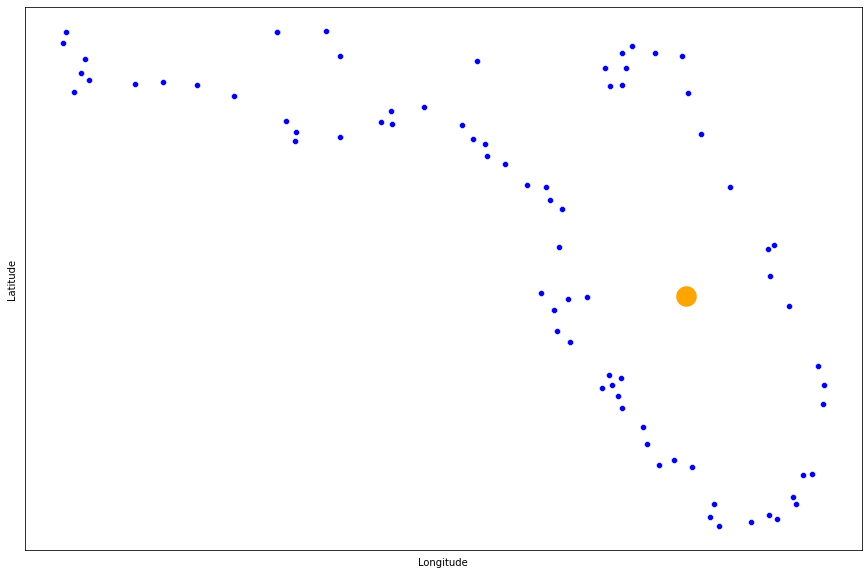

Bottom 3 Zip Codes in Florida


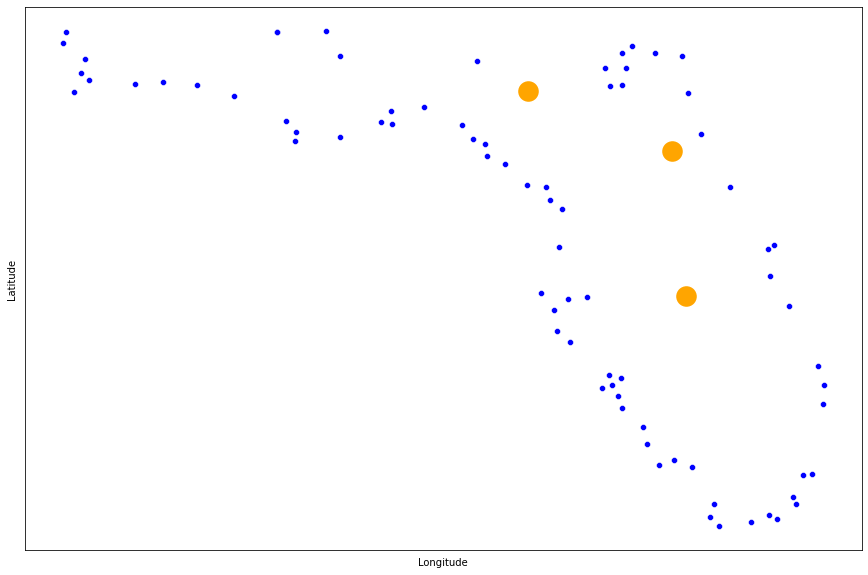

Bottom 20 Zip Codes in Florida


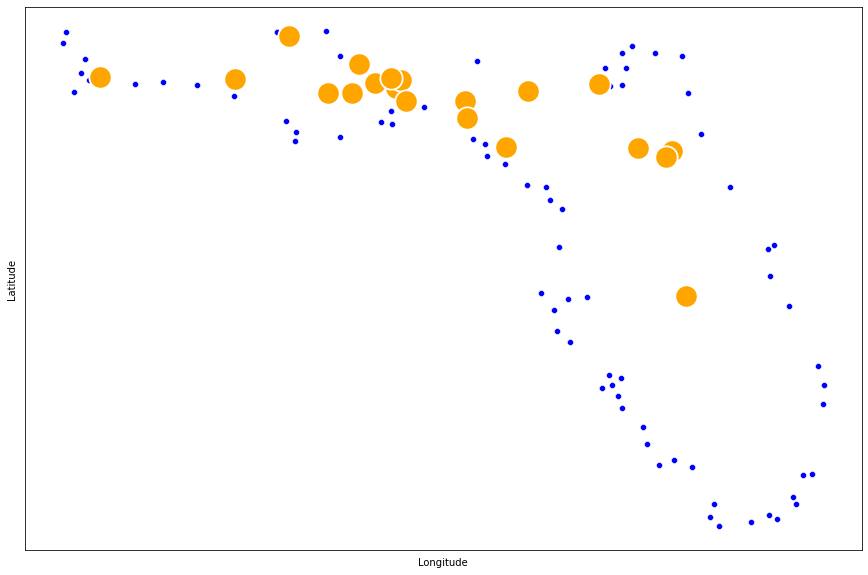

Bottom 100 Zip Codes in Florida


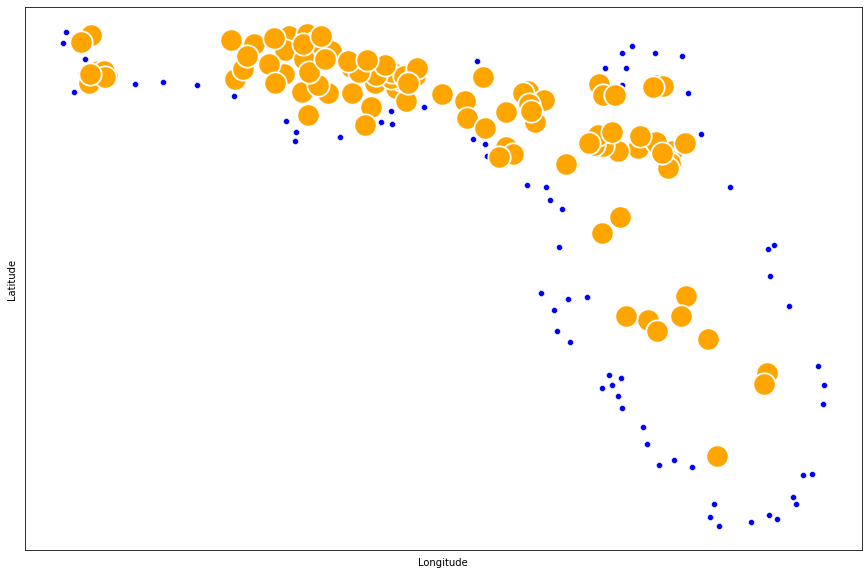

In [52]:
print('Bottom Zip Code in Florida')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'FL'], color = 'blue')
map_point = zip_forecast_2023_FL[zip_forecast_2023_FL['Forecast_Rank_ASC'] == 1][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Bottom 3 Zip Codes in Florida')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'FL'], color = 'blue')
map_point = zip_forecast_2023_FL[(zip_forecast_2023_FL['Forecast_Rank_ASC'] >= 1) & (zip_forecast_2023_FL['Forecast_Rank_ASC'] <= 3)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Bottom 20 Zip Codes in Florida')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'FL'], color = 'blue')
map_point = zip_forecast_2023_FL[(zip_forecast_2023_FL['Forecast_Rank_ASC'] >= 1) & (zip_forecast_2023_FL['Forecast_Rank_ASC'] <= 20)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Bottom 100 Zip Codes in Florida')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'FL'], color = 'blue')
map_point = zip_forecast_2023_FL[(zip_forecast_2023_FL['Forecast_Rank_ASC'] >= 1) & (zip_forecast_2023_FL['Forecast_Rank_ASC'] <= 100)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

Rochester, NY Metro Area Analysis

In [53]:
zip_forecast_2023_ROC = forecast_year_zipcode_rank(data, train_start_year = 1996, train_end_year = 2022, forecast_year = 2023, year_field = 'Year', forecast_field = 'Quantity', diff = True, \
    condition = 'Metro = Rochester, NY')

zip_forecast_2023_ROC = zip_forecast_2023_ROC.merge(data[['ZipCode', 'Latitude', 'Longitude']], left_index = True, right_on = 'ZipCode').set_index('ZipCode').drop_duplicates()

zip_forecast_2023_ROC

,Quantity,Forecast,Actual_-_Forecast,%_Error,Forecast_Rank_ASC,Forecast_Rank_DESC,Latitude,Longitude
ZipCode,,,,,,,,
14605,73350.920781,16139.057114,57211.863667,0.779975,1,107,43.168428,-77.602642
14621,87151.303381,16424.656146,70726.647235,0.811539,2,106,43.189939,-77.603649
14545,122401.972152,17261.947911,105140.024241,0.858973,3,105,42.664857,-77.701007
14608,103297.275231,17917.604276,85379.670956,0.826543,4,104,43.154099,-77.622930
14617,224959.925355,20292.016547,204667.908808,0.909797,5,103,43.225497,-77.593527
...,...,...,...,...,...,...,...,...
14418,332009.414369,78780.266824,253229.147545,0.762717,103,5,42.604430,-77.216428
14564,423419.958895,86238.786089,337181.172806,0.796328,104,4,42.986699,-77.434360
14837,299061.850637,88972.963279,210088.887358,0.702493,105,3,42.490667,-77.026107


Top Forecasted Zip Codes in Rochester, NY Metro Area for 2023

Top Zip Code in Rochester, New York


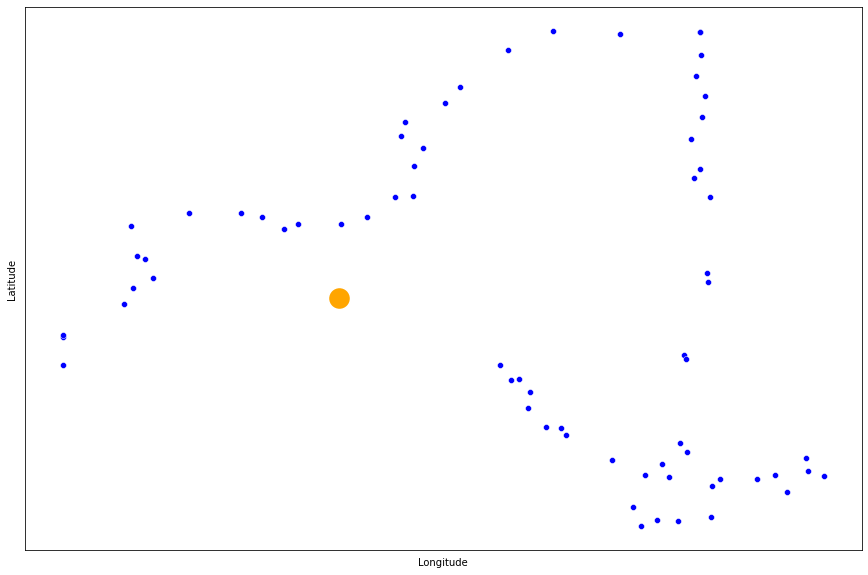

Top 3 Zip Codes in Rochester, New York


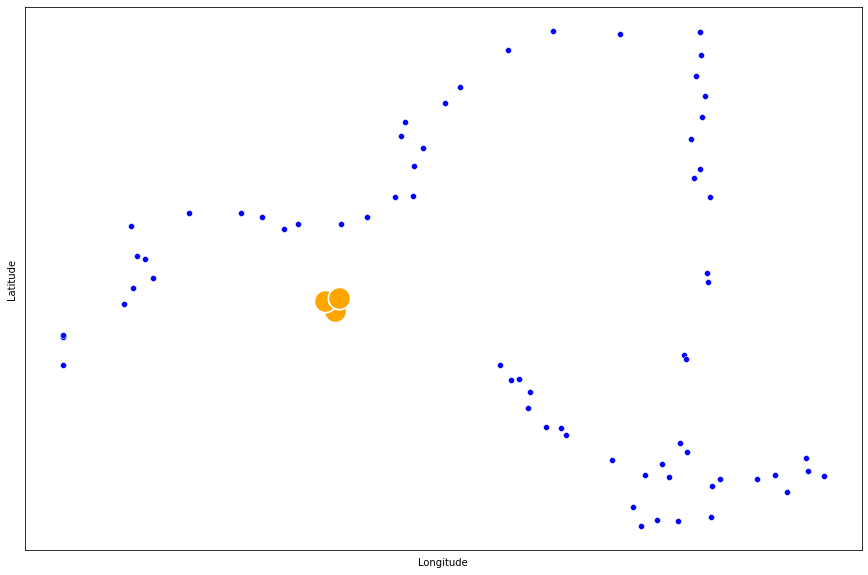

Top 20 Zip Codes in Rochester, New York


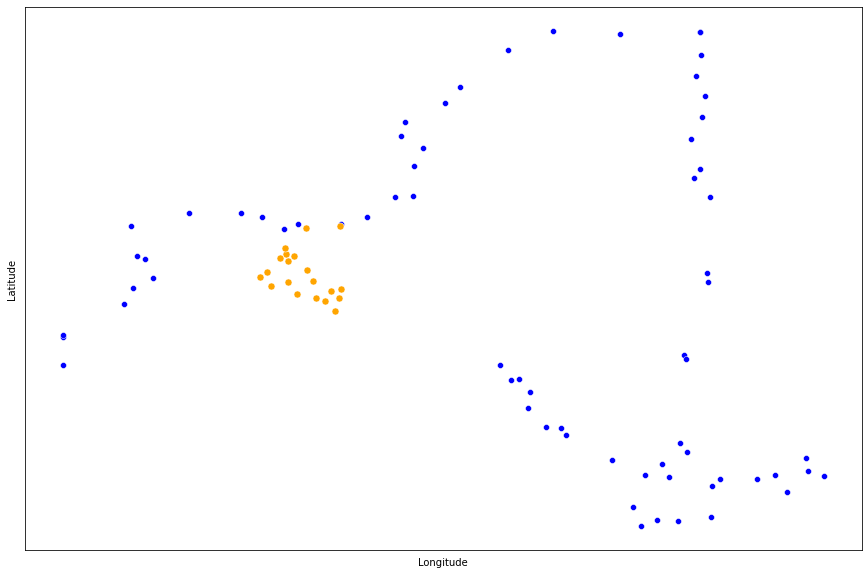

In [54]:
print('Top Zip Code in Rochester, New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_ROC[zip_forecast_2023_ROC['Forecast_Rank_DESC'] == 1][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Top 3 Zip Codes in Rochester, New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_ROC[(zip_forecast_2023_ROC['Forecast_Rank_DESC'] >= 1) & (zip_forecast_2023_ROC['Forecast_Rank_DESC'] <= 3)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Top 20 Zip Codes in Rochester, New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_ROC[(zip_forecast_2023_ROC['Forecast_Rank_DESC'] >= 1) & (zip_forecast_2023_ROC['Forecast_Rank_DESC'] <= 20)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 50)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

Bottom Forecasted Zip Codes in Rochester, NY Metro Area for 2023

Bottom Zip Code in Rochester, New York


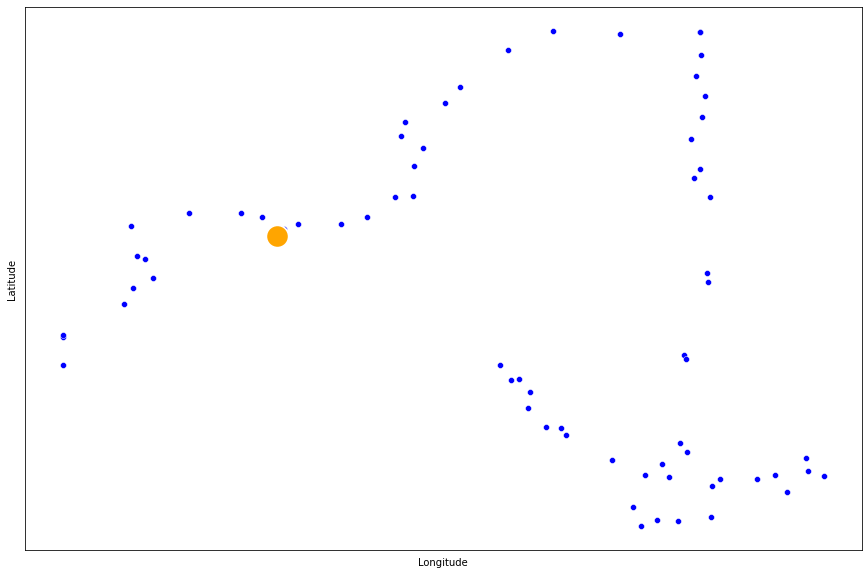

Bottom 3 Zip Codes in Rochester, New York


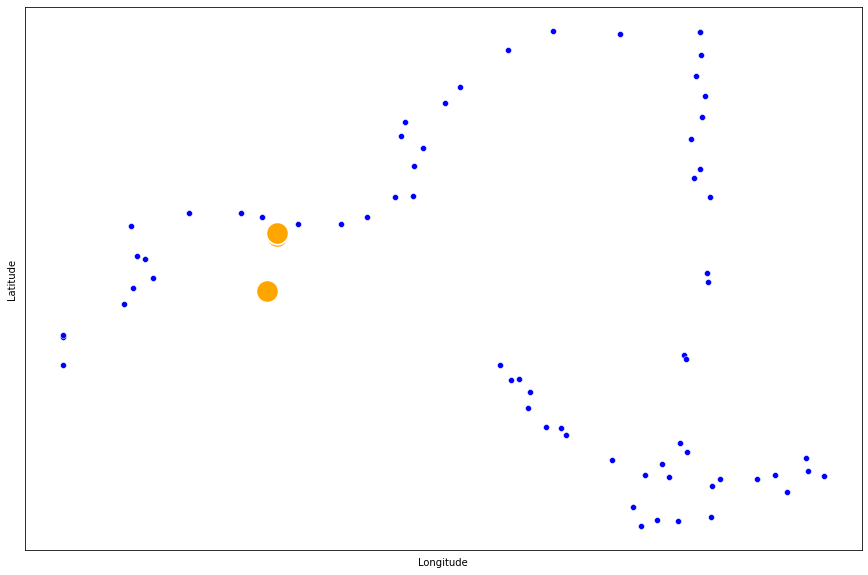

Bottom 20 Zip Codes in Rochester, New York


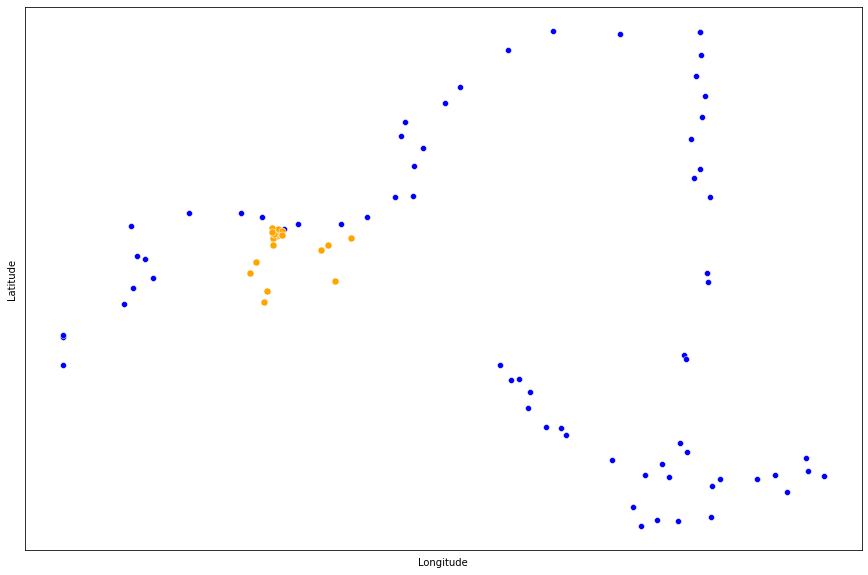

In [55]:
print('Bottom Zip Code in Rochester, New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_ROC[zip_forecast_2023_ROC['Forecast_Rank_ASC'] == 1][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Bottom 3 Zip Codes in Rochester, New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_ROC[(zip_forecast_2023_ROC['Forecast_Rank_ASC'] >= 1) & (zip_forecast_2023_ROC['Forecast_Rank_ASC'] <= 3)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

print('Bottom 20 Zip Codes in Rochester, New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_ROC[(zip_forecast_2023_ROC['Forecast_Rank_ASC'] >= 1) & (zip_forecast_2023_ROC['Forecast_Rank_ASC'] <= 20)][['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 50)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

Now, in conclusion, to answer the following questions: \
&nbsp;&nbsp;&nbsp;&nbsp;- What techniques/algorithms/decision processes were used to down sample? \
&nbsp;&nbsp;&nbsp;&nbsp;- What three zip codes provide the best investment opportunity for the SREIT (Syracuse Real Estate Investment Trust)?


Question 1 - What techniques/algorithms/decision processes were used to down sample? \
\
The main reason for down sampling was due to system local memory restrictions and model generation latency. When models were fitted on the full un-subsetted data, the machine either ran out of local memory or it was taking too much time to create. The subsets themselves were picked either due to instrictions (Arkansas), my home state (New York), my home city (Rochester, NY), or being a highly-populated state with good border coordinate data (Florida).

Qustion 2 - What three zip codes provide the best investment opportunity for the SREIT (Syracuse Real Estate Investment Trust)? \
\
For this, we will repeat the zip code 2023 forecasting, this time for the Syracuse, NY metro area. We will show the top 3 zip codes both on a map and in a resulting DataFrame. The resulting DataFrame will need to be joined to the comined DataFrame for the name of the city and geospatial data for the zip codes.

In [56]:
zip_forecast_2023_SYR_TOP_3 = forecast_year_zipcode_rank(data, train_start_year = 1996, train_end_year = 2022, forecast_year = 2023, year_field = 'Year', forecast_field = 'Quantity', diff = True, \
    condition = 'Metro = Syracuse, NY')

zip_forecast_2023_SYR_TOP_3 = zip_forecast_2023_SYR_TOP_3.merge(data[['ZipCode', 'CityState', 'Latitude', 'Longitude']], left_index = True, right_on = 'ZipCode').set_index('ZipCode').drop_duplicates()

zip_forecast_2023_SYR_TOP_3 = zip_forecast_2023_SYR_TOP_3[(zip_forecast_2023_SYR_TOP_3['Forecast_Rank_DESC'] >= 1) & (zip_forecast_2023_SYR_TOP_3['Forecast_Rank_DESC'] <= 3)]

zip_forecast_2023_SYR_TOP_3[['CityState']]

,CityState
ZipCode,
13110,"Marietta, NY"
13078,"Jamesville, NY"
13152,"Skaneateles, NY"


Top 3 Zip Codes in Syracuse, New York


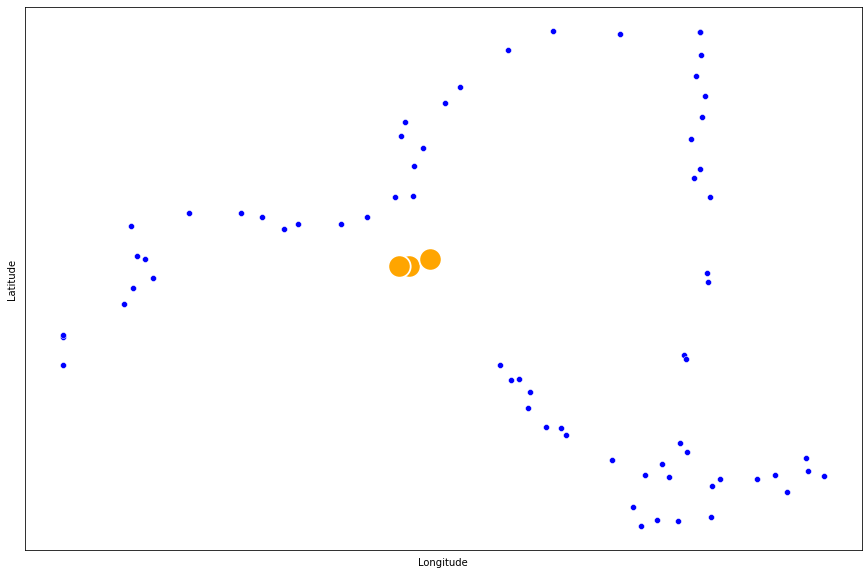

In [57]:
print('Top 3 Zip Codes in Syracuse, New York')
pyplot.figure(figsize = (15,10))
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = border_data[border_data['State'] == 'NY'], color = 'blue')
map_point = zip_forecast_2023_SYR_TOP_3[['Latitude', 'Longitude']]
seaborn.scatterplot(x = 'Longitude', y = 'Latitude', data = map_point, color = 'orange', s = 500)
pyplot.xticks([])
pyplot.yticks([])
pyplot.show()

End of Lab 2.